In [1]:
'''
Aim: get differential expressed interactions
Author:Yike Xie
Date: Sep 2022
'''

'\nAim:\nAuthor:\nDate:\n'

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams

import seaborn as sns

In [3]:
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/figure_cyto/'

In [4]:
res = pd.read_excel('/home/yike/phd/dengue/data/Luca_cyto_exp.xlsx', sheet_name='results', skiprows=[0])

# exclude VCAM1
cols = res.columns.tolist()
cols.remove('VCAM1')
res = res[cols]

res = res.set_index(['Condition', 'ID'])
res = res.replace(['<0.03', '<3.00', '<4.80'], 0)

res = res.astype('float').loc[['H', 'D', 'DWS', 'SD']]

###############################
ct_pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/ct_pair.tsv', 
                      sep='\t', index_col=['cell_subtype', 'gene'])

cst_pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/cst_pair.tsv', 
                       sep='\t', index_col=['cell_subtype', 'gene'])

###############################
# load differential expressed cytokines according to Luca's experiment
exp_info = pd.read_excel('/home/yike/phd/dengue/data/Luca_cyto_exp.xlsx',
                        sheet_name='sig_cytos', skiprows=[0,1], index_col=0)

cts = ['Monocytes', 'NK cells', 'Plasmablasts', 'B cells', 'T cells', 
      'conventional DCs', 'plasmacytoid DCs','megakaryocytes', ]
csts = [
         'classical monocytes',
         'non-classical monocytes',
         'intermediate monocytes',
         
         'cytotoxic NK cells',
         'signaling NK cells',
    
         'proliferating plasmablasts',
         'non-proliferating plasmablasts',
    
         'naive B cells',
         'memory B cells',
         'activated B cells',

         'CD4+ naive T cells',
         'CD4+ memory T cells',
         'CD8+ naive T cells',
         'CD8+ effector memory T cells',
         'CD8+ exhausted T cells',
         'MAIT',
         'Tregs',

         'cDC1',
         'cDC2',
         'pDCs',
         'megakaryocytes',]

In [5]:
# load significant cytokines
pair = pd.read_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/cytokines/cyto_pair.tsv', 
            sep='\t', index_col='gene')
sig_cytos = pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD']).index

In [15]:
def data_show(pair, res, pvalue, cds):
    
    idx_ks = pair[pair[pvalue] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index
    idx_not = [idx for idx in pair.index if idx not in idx_ks]
    idx_ks_rest = pair.loc[idx_not].sort_values(['med_pair', 'avg_SD'], ascending=False).index

    ks_data = np.log10(res[idx_ks].loc[cds].reset_index().set_index('ID')[
        res[idx_ks].loc[cds].reset_index().set_index('ID').columns[1:]] + 0.1)

    all_data_ks = np.log10(res[idx_ks.tolist() + idx_ks_rest.tolist()].loc[cds].reset_index().set_index('ID')[
        res[idx_ks.tolist() + idx_ks_rest.tolist()].loc[cds].reset_index().set_index('ID').columns[1:]] + 0.1)
    
    return all_data_ks

def heatmap(res_data, row_colors, title=False):
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    cmap = sns.color_palette("vlag", as_cmap=True) # 'vlag', 'Greys'

    g = sns.clustermap(res_data.T, col_colors=row_colors, col_cluster=False, row_cluster=False,
                       figsize=[2 + 0.5 * res_data.shape[0], 5 + 0.5 * res_data.shape[1]], cmap=cmap, 
                       cbar_pos=(1, 0.1, .03, .2), vmin=-1, vmax=6.5,
                       dendrogram_ratio=0.01, colors_ratio=0.01,
                       cbar_kws={'label':'Concentration', 'shrink': 0.1,
                                 'ticks':[np.log10(0 + .1), 
                                           np.log10(1e2 + .1),
                                          np.log10(1e4 + .1), 
                                          np.log10(1e6 + .1),
                                         ],})
    
    g.ax_heatmap.set_xlabel(None)
    g.ax_cbar.set_yticklabels([0, '$10^2$', '$10^4$', '$10^6$'])
    
    g.fig.tight_layout()
    if title is not False:
        g.fig.savefig(save_figures + 'heatmap_' + title + '.png', bbox_inches='tight')
        g.fig.savefig(save_figures + 'heatmap_' + title + '.pdf', bbox_inches='tight')

<ipython-input-82-716209679bc8>:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  g.fig.tight_layout()


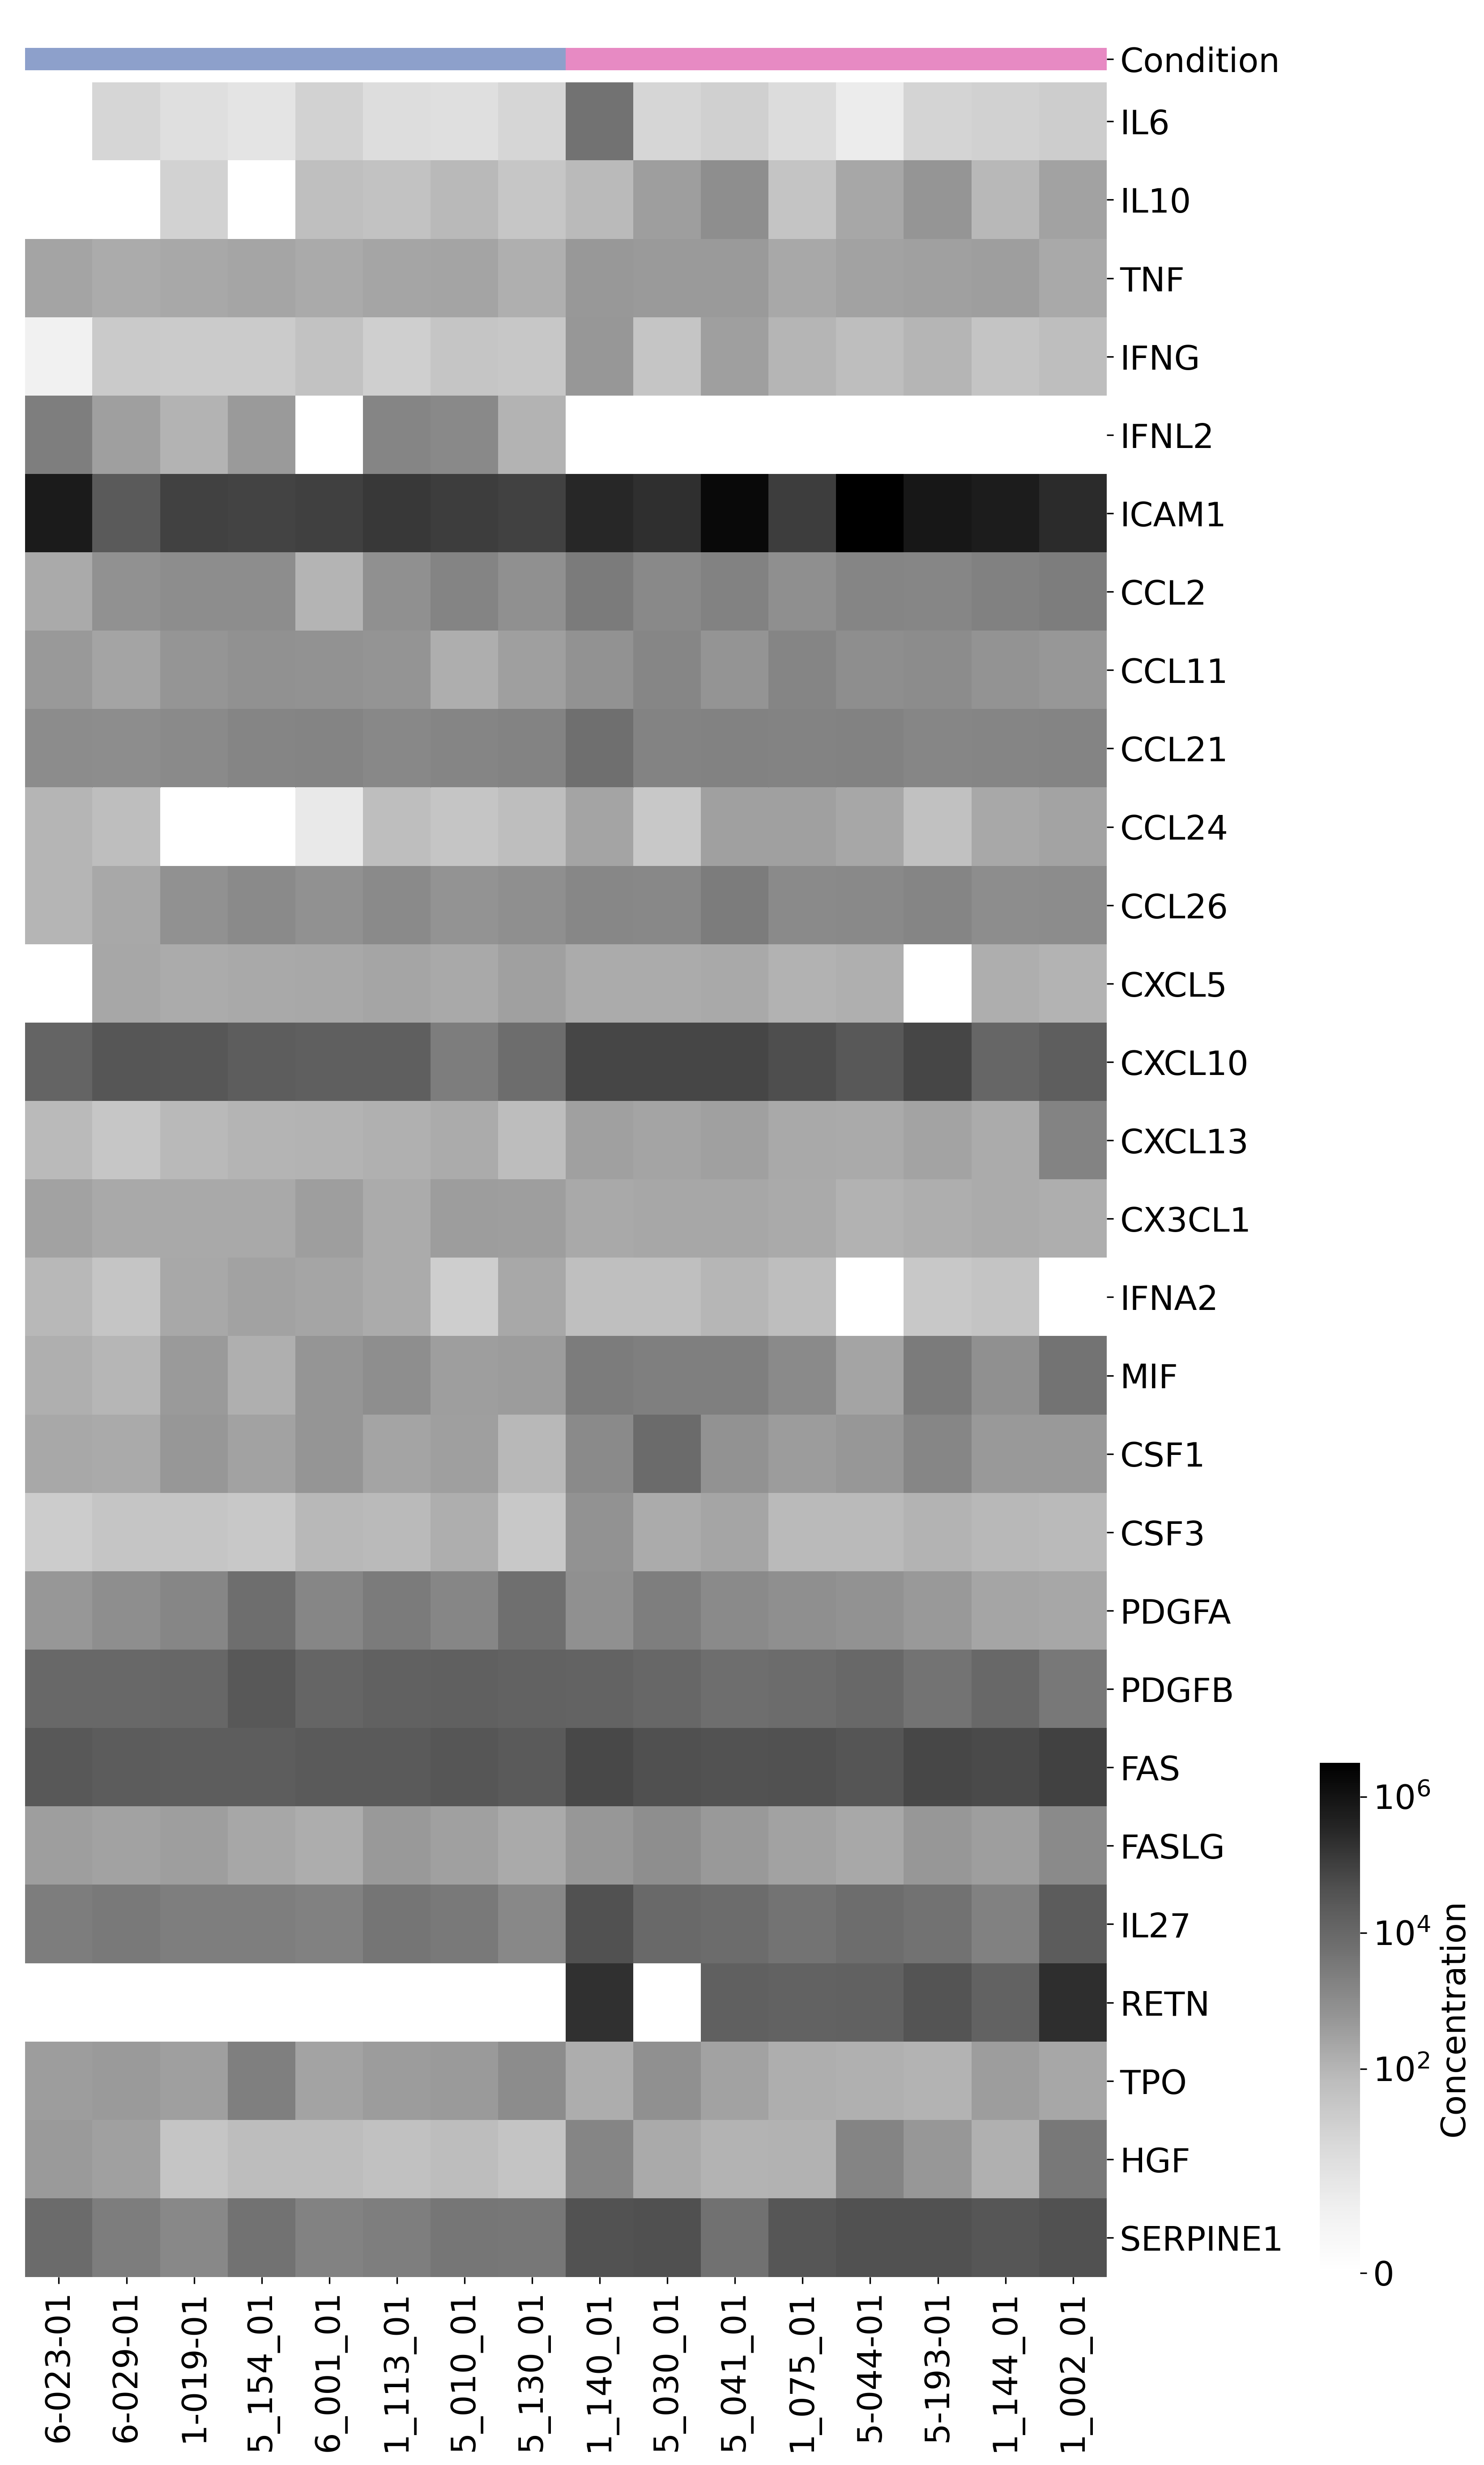

In [83]:
genes_show = [
    # pro-inflammation
    'IL6', 'IL10', 'TNF', 'IFNG', 'IFNL2',
    # cell migration
    'ICAM1',  'CCL2','CCL11','CCL21','CCL24','CCL26','CXCL5','CXCL10', 'CXCL13', 'CX3CL1', 
    # innate immune response
    'IFNA2', 'MIF',
    # leucocyte differentiation
    'CSF1', 'CSF3', 'PDGFA', 'PDGFB',
    # activation induced cell death
    'FAS', 'FASLG',
    # pro and anti-inflammation
    'IL27',
    # hermone
    'RETN', 'TPO',
    # cell development
    'HGF', 
    # hemostasis
    'SERPINE1'
]

colors=sns.color_palette('Set2', 4)
cmap_dic = {'H': colors[0], 'D': colors[2], 'DWS': colors[1], 'SD': colors[3]}
row_colors = res.reset_index().set_index('ID')['Condition'].map(cmap_dic)
U_data = data_show(pair, res, 'pvalue_U', ['D', 'SD'])
heatmap(U_data[genes_show], row_colors, title='group_cyto_D_SD')

<ipython-input-15-cf0b86b8385c>:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  g.fig.tight_layout()


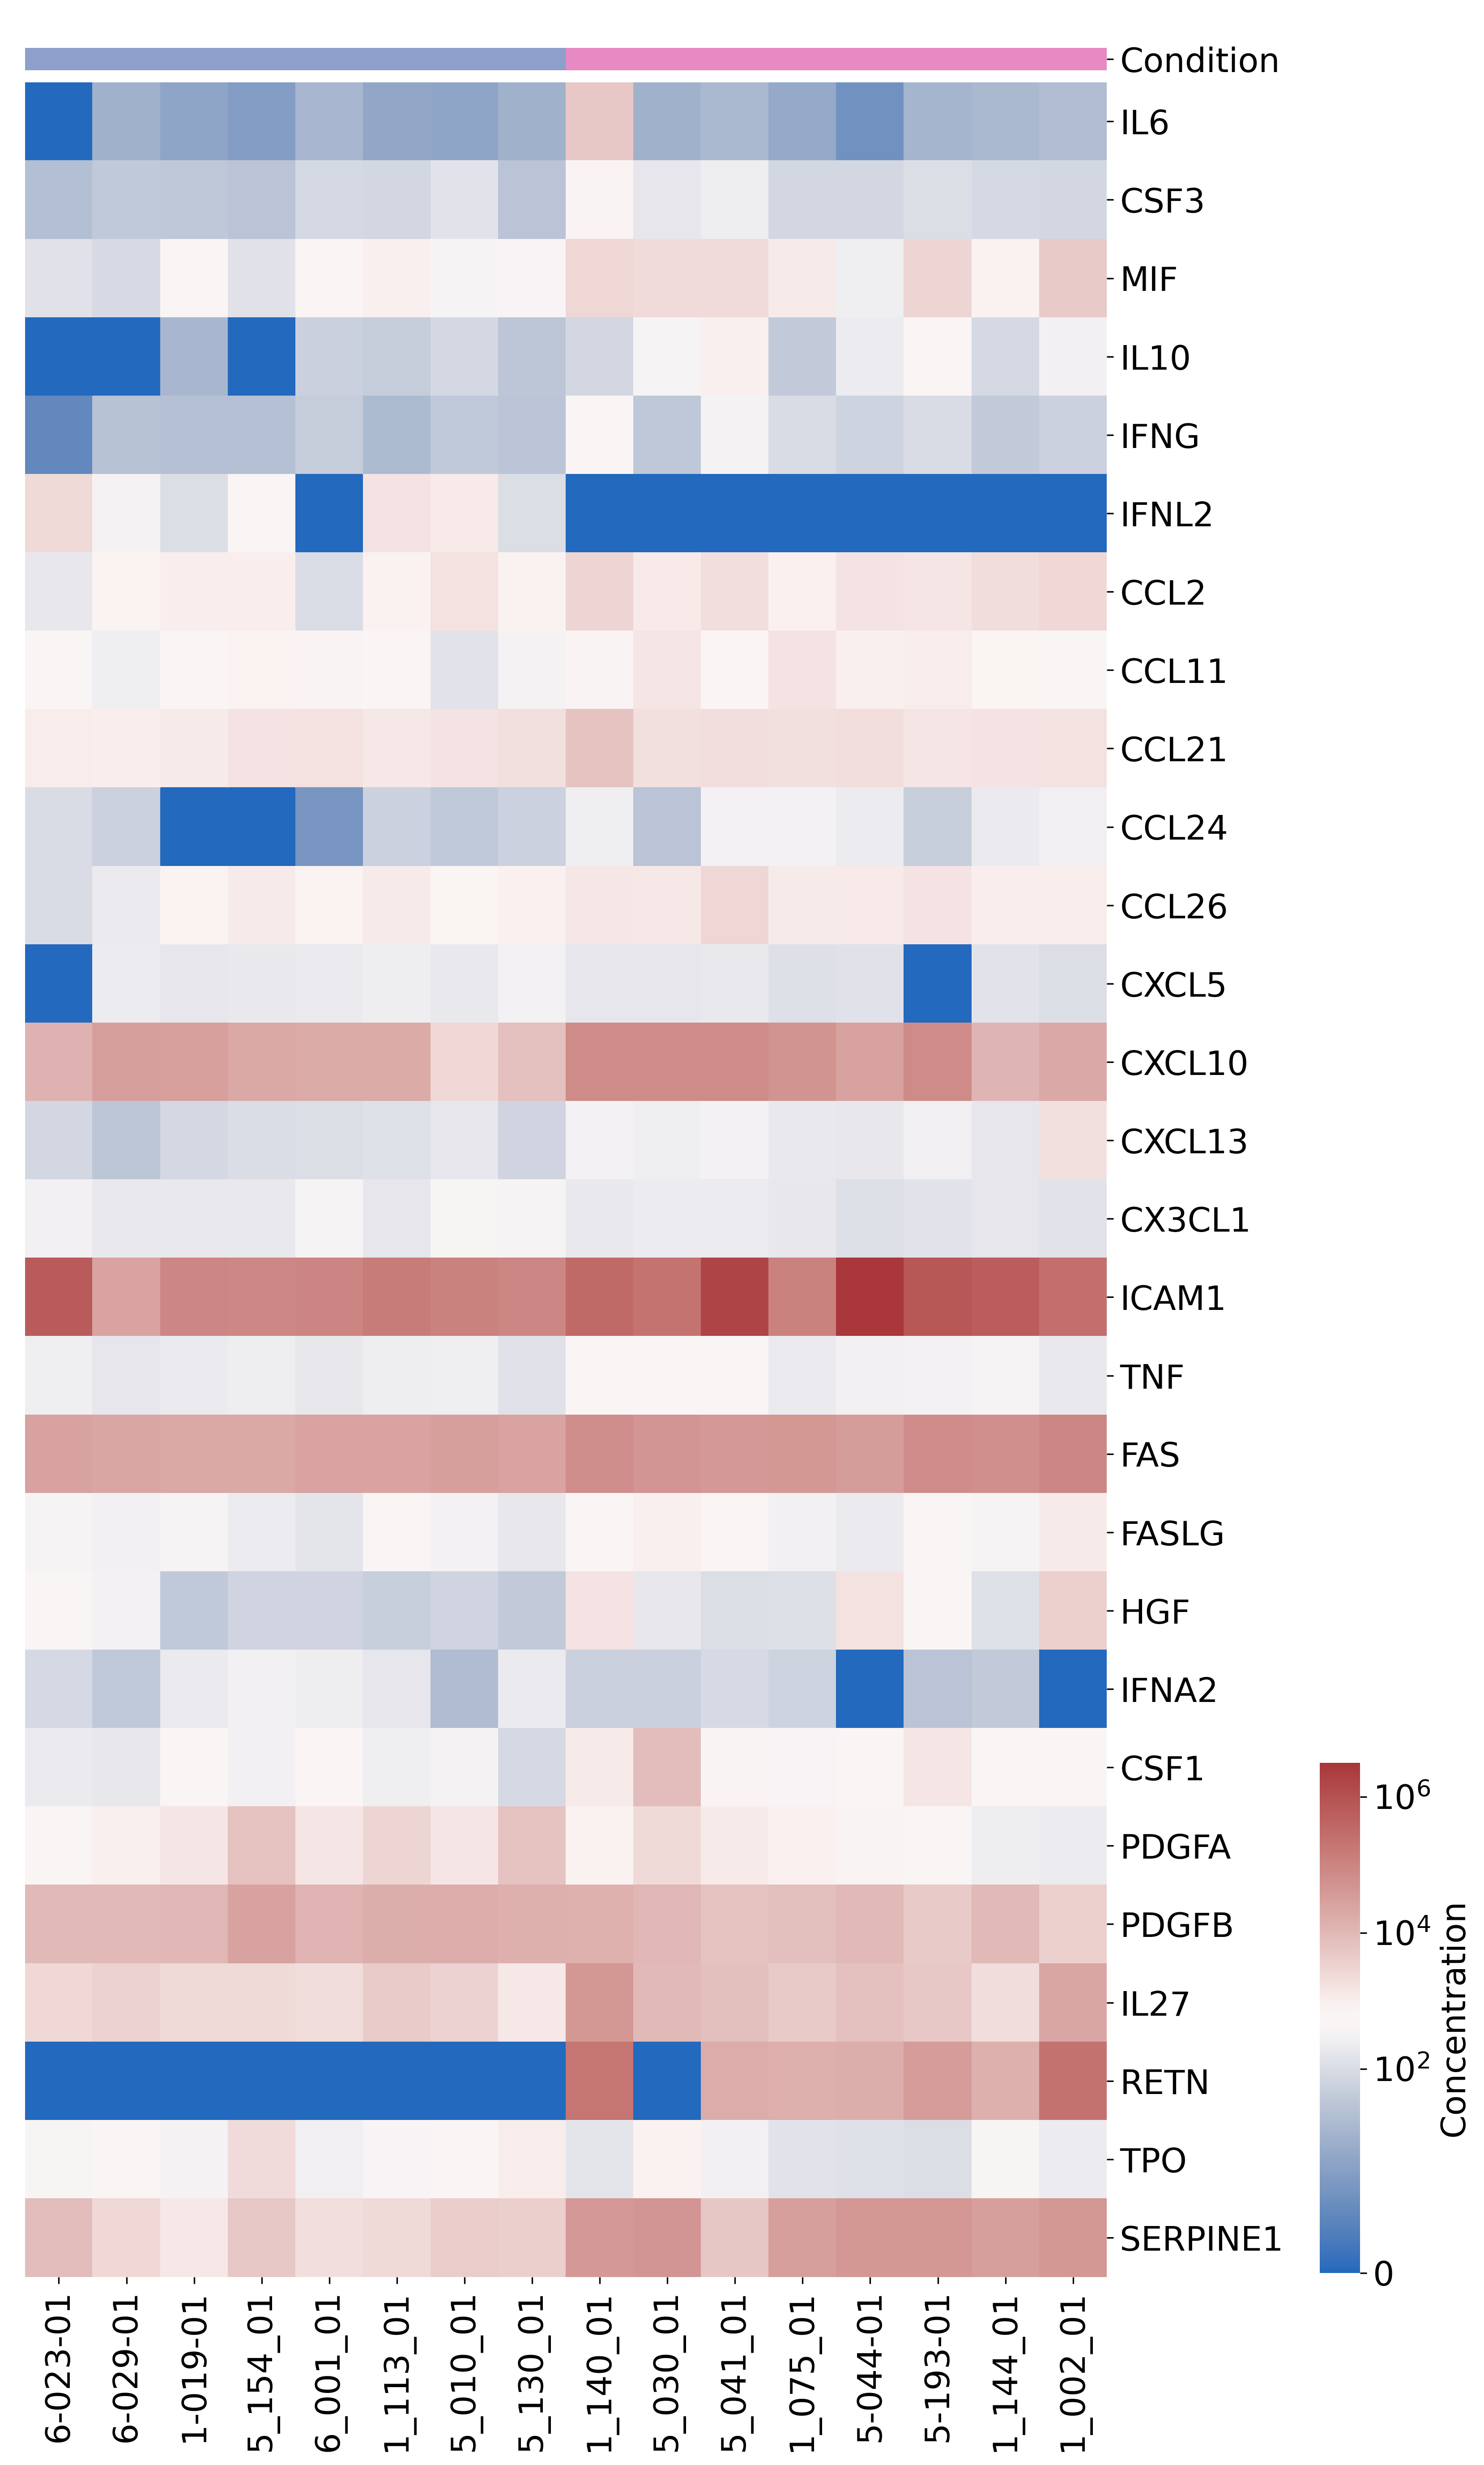

In [16]:
genes_show = [
    # proinflamation
    'IL6', 'CSF3', 'MIF', 'IL10', 'IFNG', 'IFNL2',
    # anti-inflammatory cytokines
    # Immunoregulatory cytokines
    
    # Cell migration
     'CCL2','CCL11','CCL21','CCL24','CCL26','CXCL5','CXCL10', 'CXCL13', 'CX3CL1', 'ICAM1', 
    # TNF family members
    'TNF', 'FAS', 'FASLG',
    # Angiogenic and fibrogenic factors
    'HGF',

    # 
    'IFNA2', 
    'CSF1', 'PDGFA', 'PDGFB',
    'IL27',
    'RETN', 'TPO',
    'SERPINE1'
]

colors=sns.color_palette('Set2', 4)
cmap_dic = {'H': colors[0], 'D': colors[2], 'DWS': colors[1], 'SD': colors[3]}
row_colors = res.reset_index().set_index('ID')['Condition'].map(cmap_dic)
U_data = data_show(pair, res, 'pvalue_U', ['D', 'SD'])
heatmap(U_data[genes_show], row_colors, title='new_group_cyto_D_SD_c')

In [10]:
def heatmap_cst(cst_pair, g_list, cst_order, clip_vim, col_name, vs_type='SD vs D', save_fd=False):
    #rcParams['figure.figsize']=(7, 14)
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    df = cst_pair.reset_index().set_index('gene').loc[g_list][['cell_subtype', col_name]]

    df_new = pd.DataFrame(np.zeros([len(df.index.unique()), len(cst_order)]), columns=cst_order, index=g_list)

    for idx in df_new.index:    
        for col in df_new.columns:
            df_new.at[idx, col] = df.loc[idx][df.loc[idx]['cell_subtype'] == col][col_name][0]
            
    df_new = pd.DataFrame(np.clip(df_new.values, -clip_vim, clip_vim), columns=df_new.columns, index=df_new.index)
    
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    
    g = sns.clustermap(df_new, col_cluster=False, row_cluster=False,
                       cmap=cmap, center=0, yticklabels=True, vmin=-clip_vim, vmax=clip_vim,
                       cbar_kws={'label': 'log2 fold change\n[%s]'%vs_type, 'shrink': .3},
                       cbar_pos=(0.99, 0.4, .02, .2), dendrogram_ratio=0.05, colors_ratio=0.01,
                       figsize=[1 + 0.5 * len(cst_order), 0.5 * len(g_list)])
    ax = g.ax_heatmap
    ax.set_ylabel(None)
    xlabels = [label.get_text().replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels)

    if save_fd is not False:
        g.savefig(save_figures + save_fd, bbox_inches='tight')

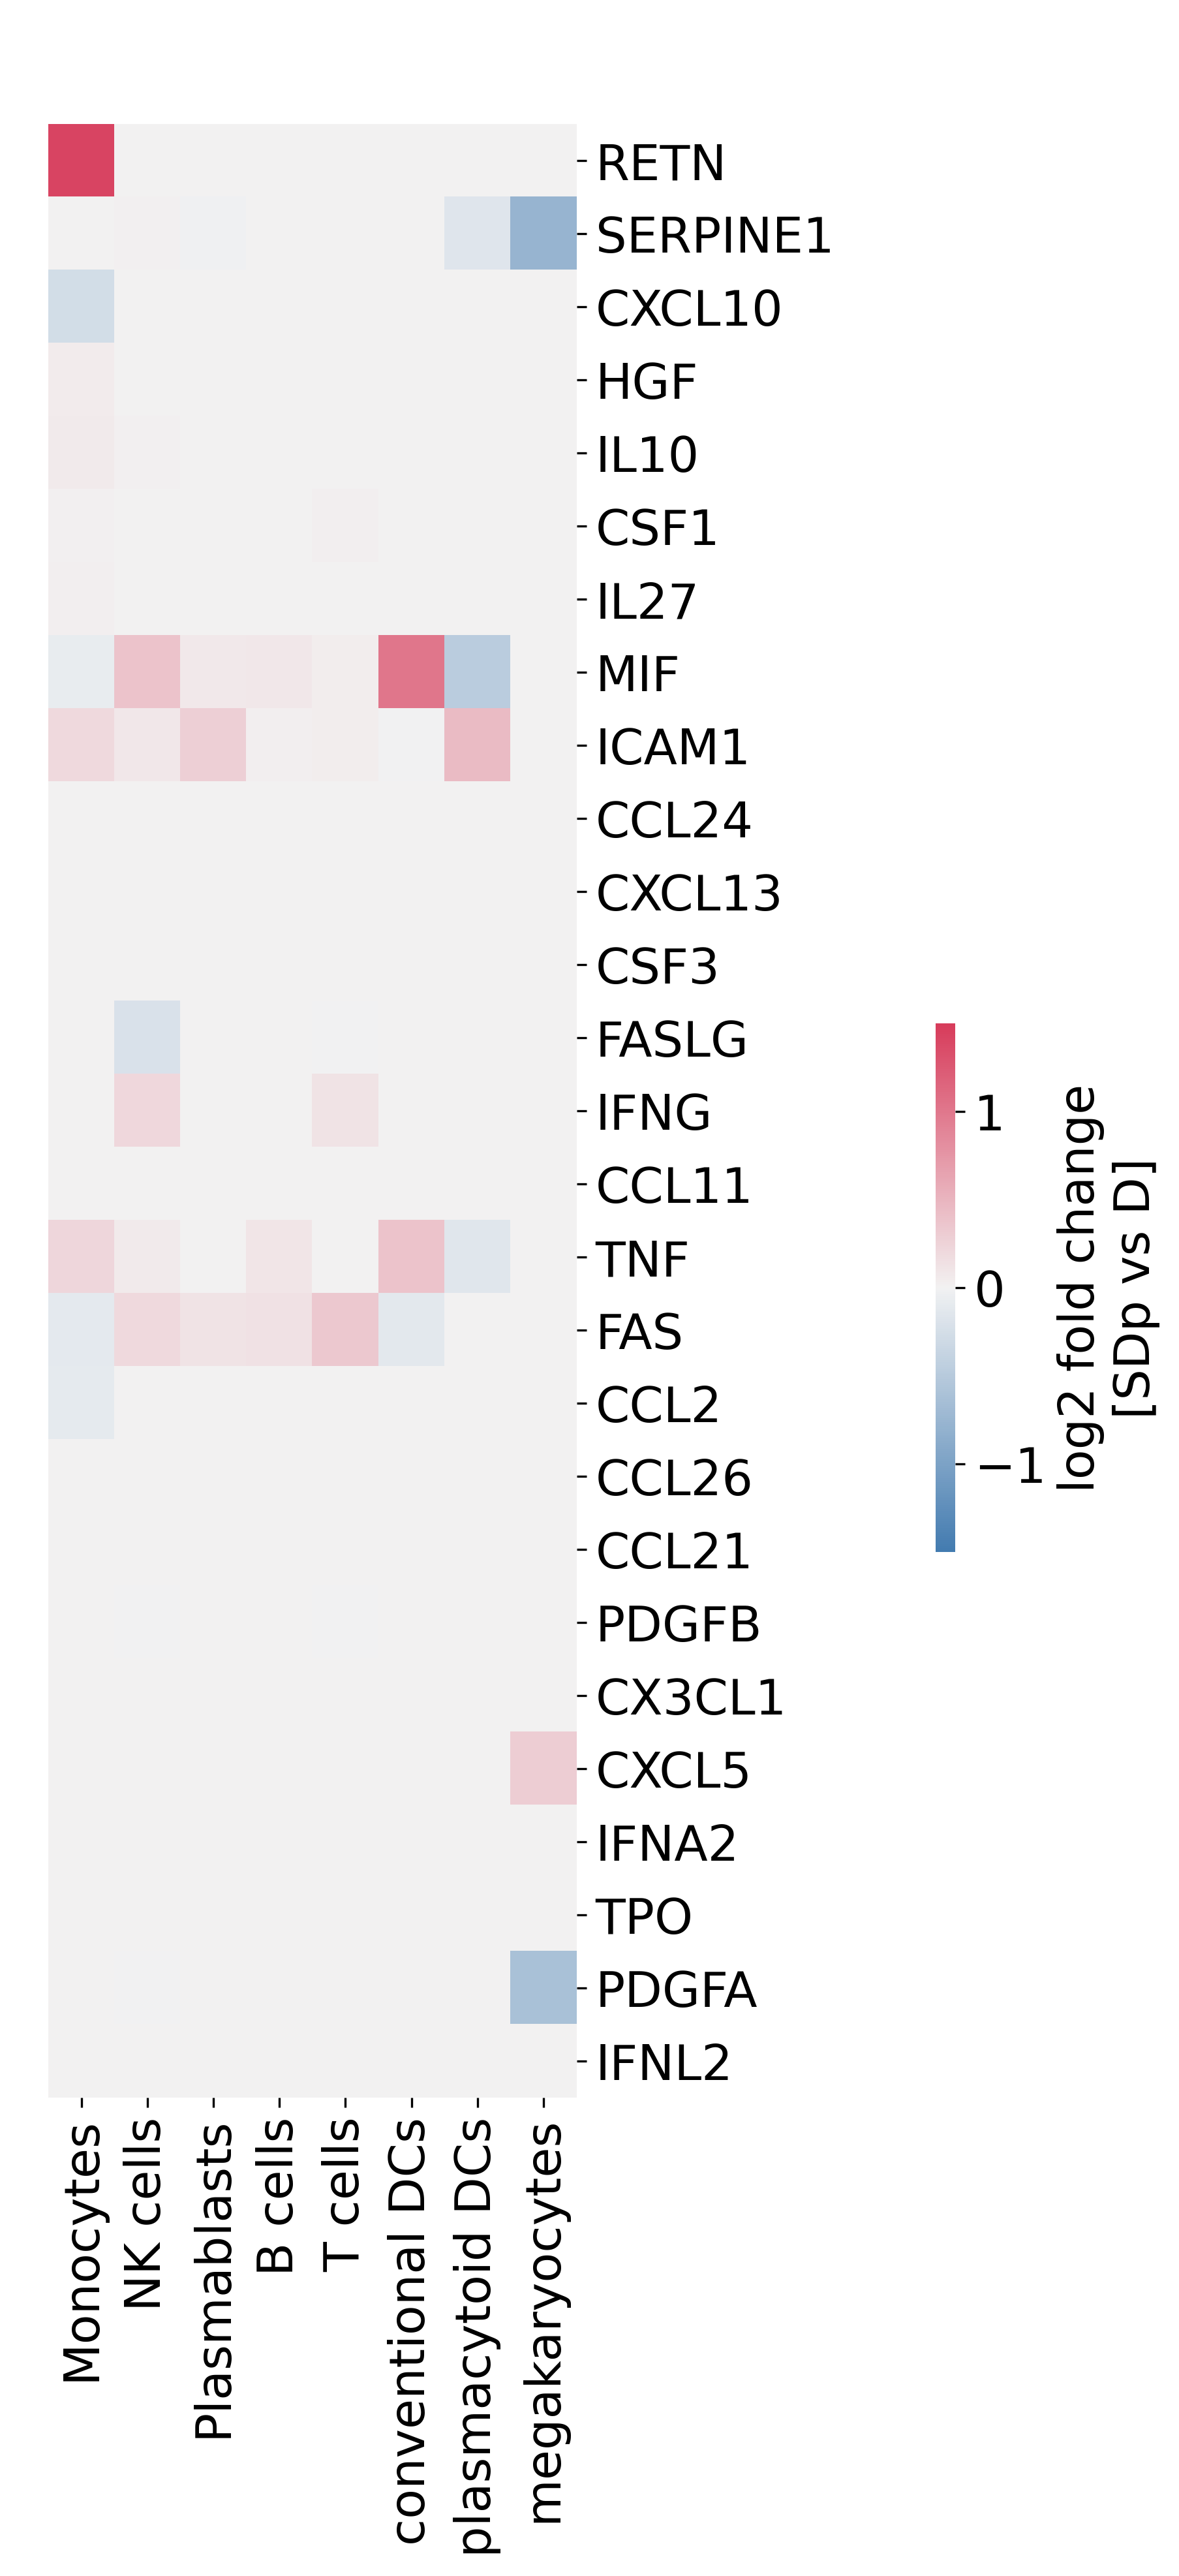

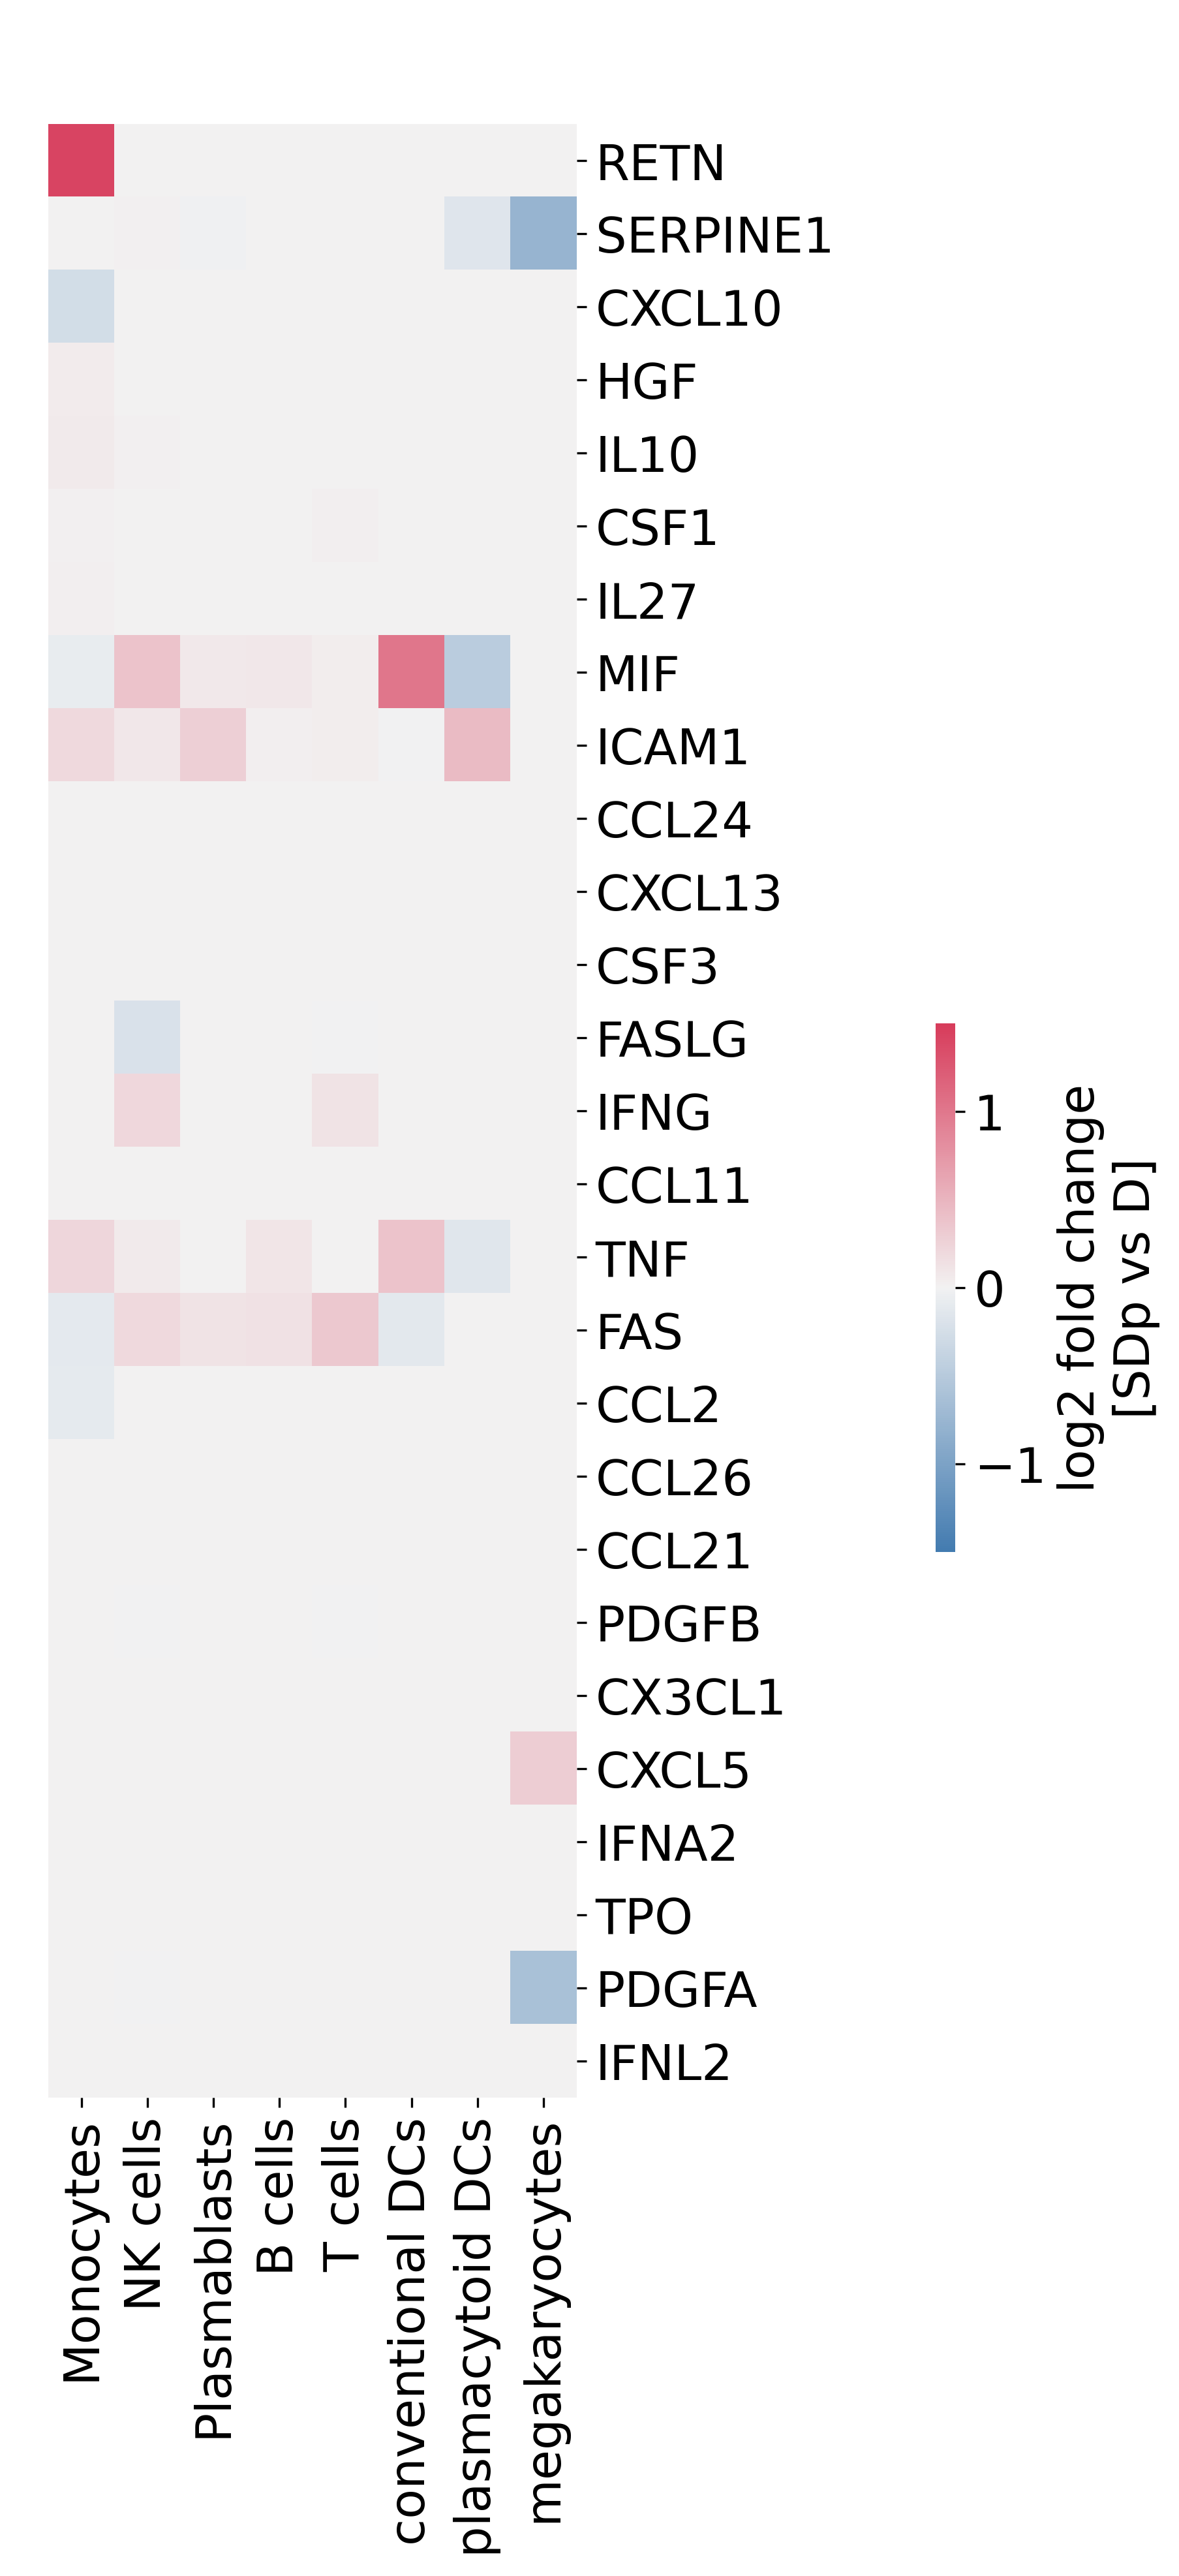

In [110]:
# '''medium log2 fold change from pairwise comparison of all significant cytokines
# in distinct cell types in our dataset'''
heatmap_cst(ct_pair, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            cts, 1.5, 'med_pair', vs_type='SDp vs D', save_fd='sig_cyto_dataset.png')
heatmap_cst(ct_pair, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            cts, 1.5, 'med_pair', vs_type='SDp vs D', save_fd='sig_cyto_dataset.pdf')

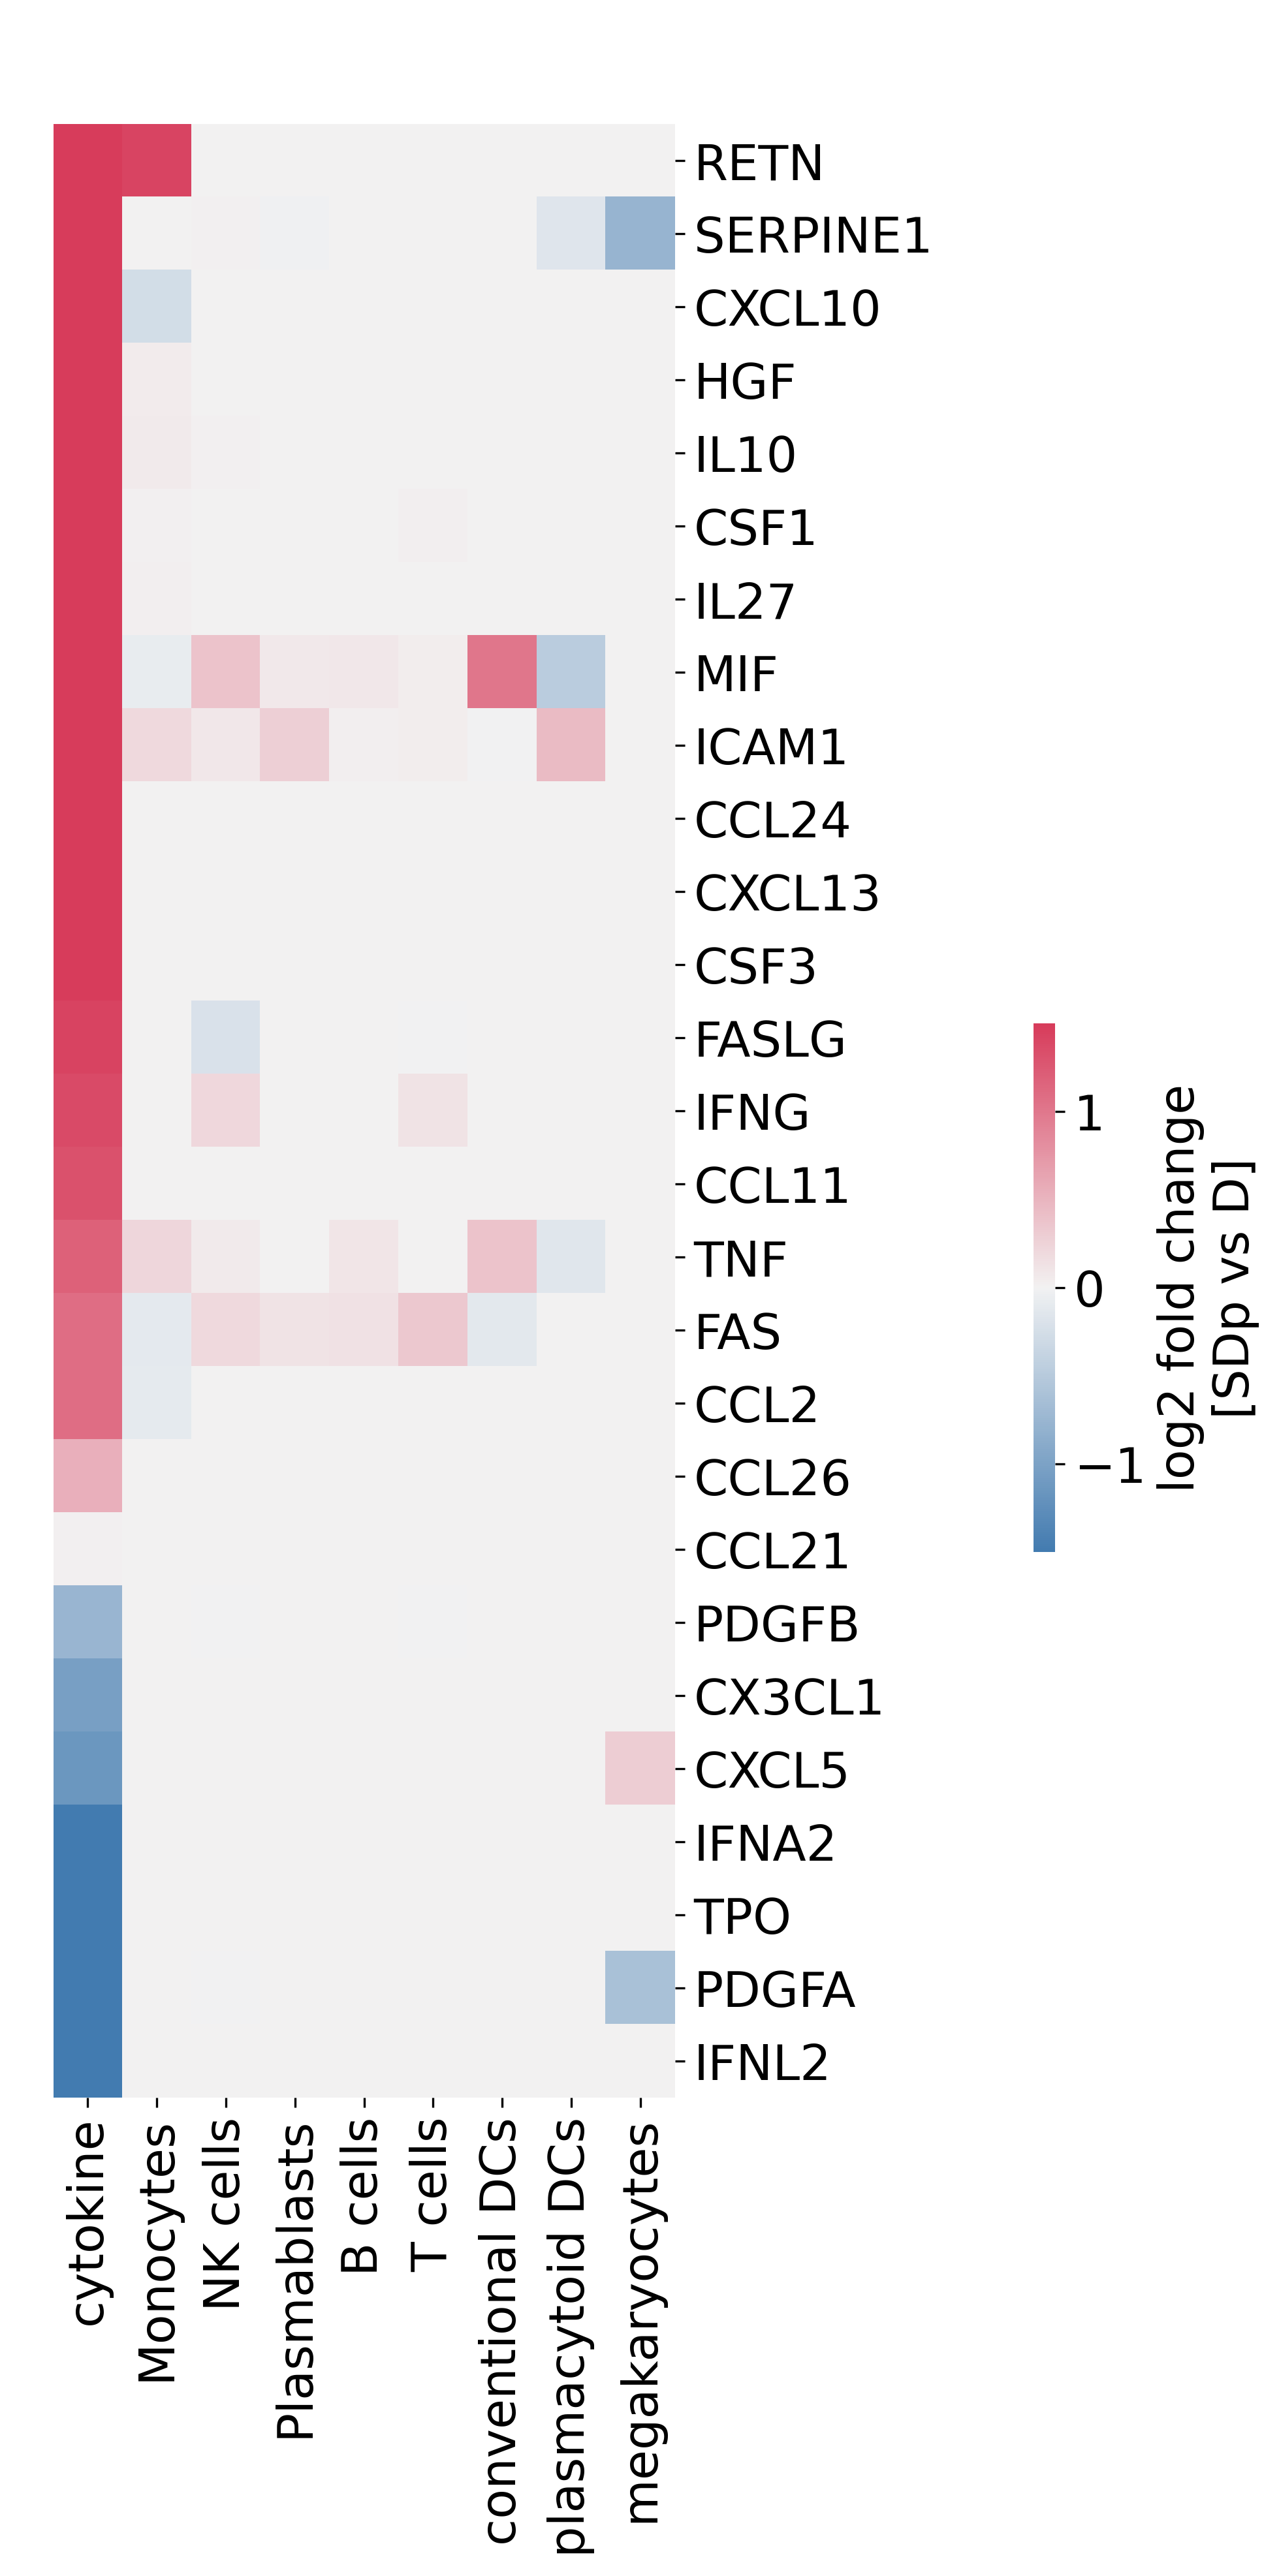

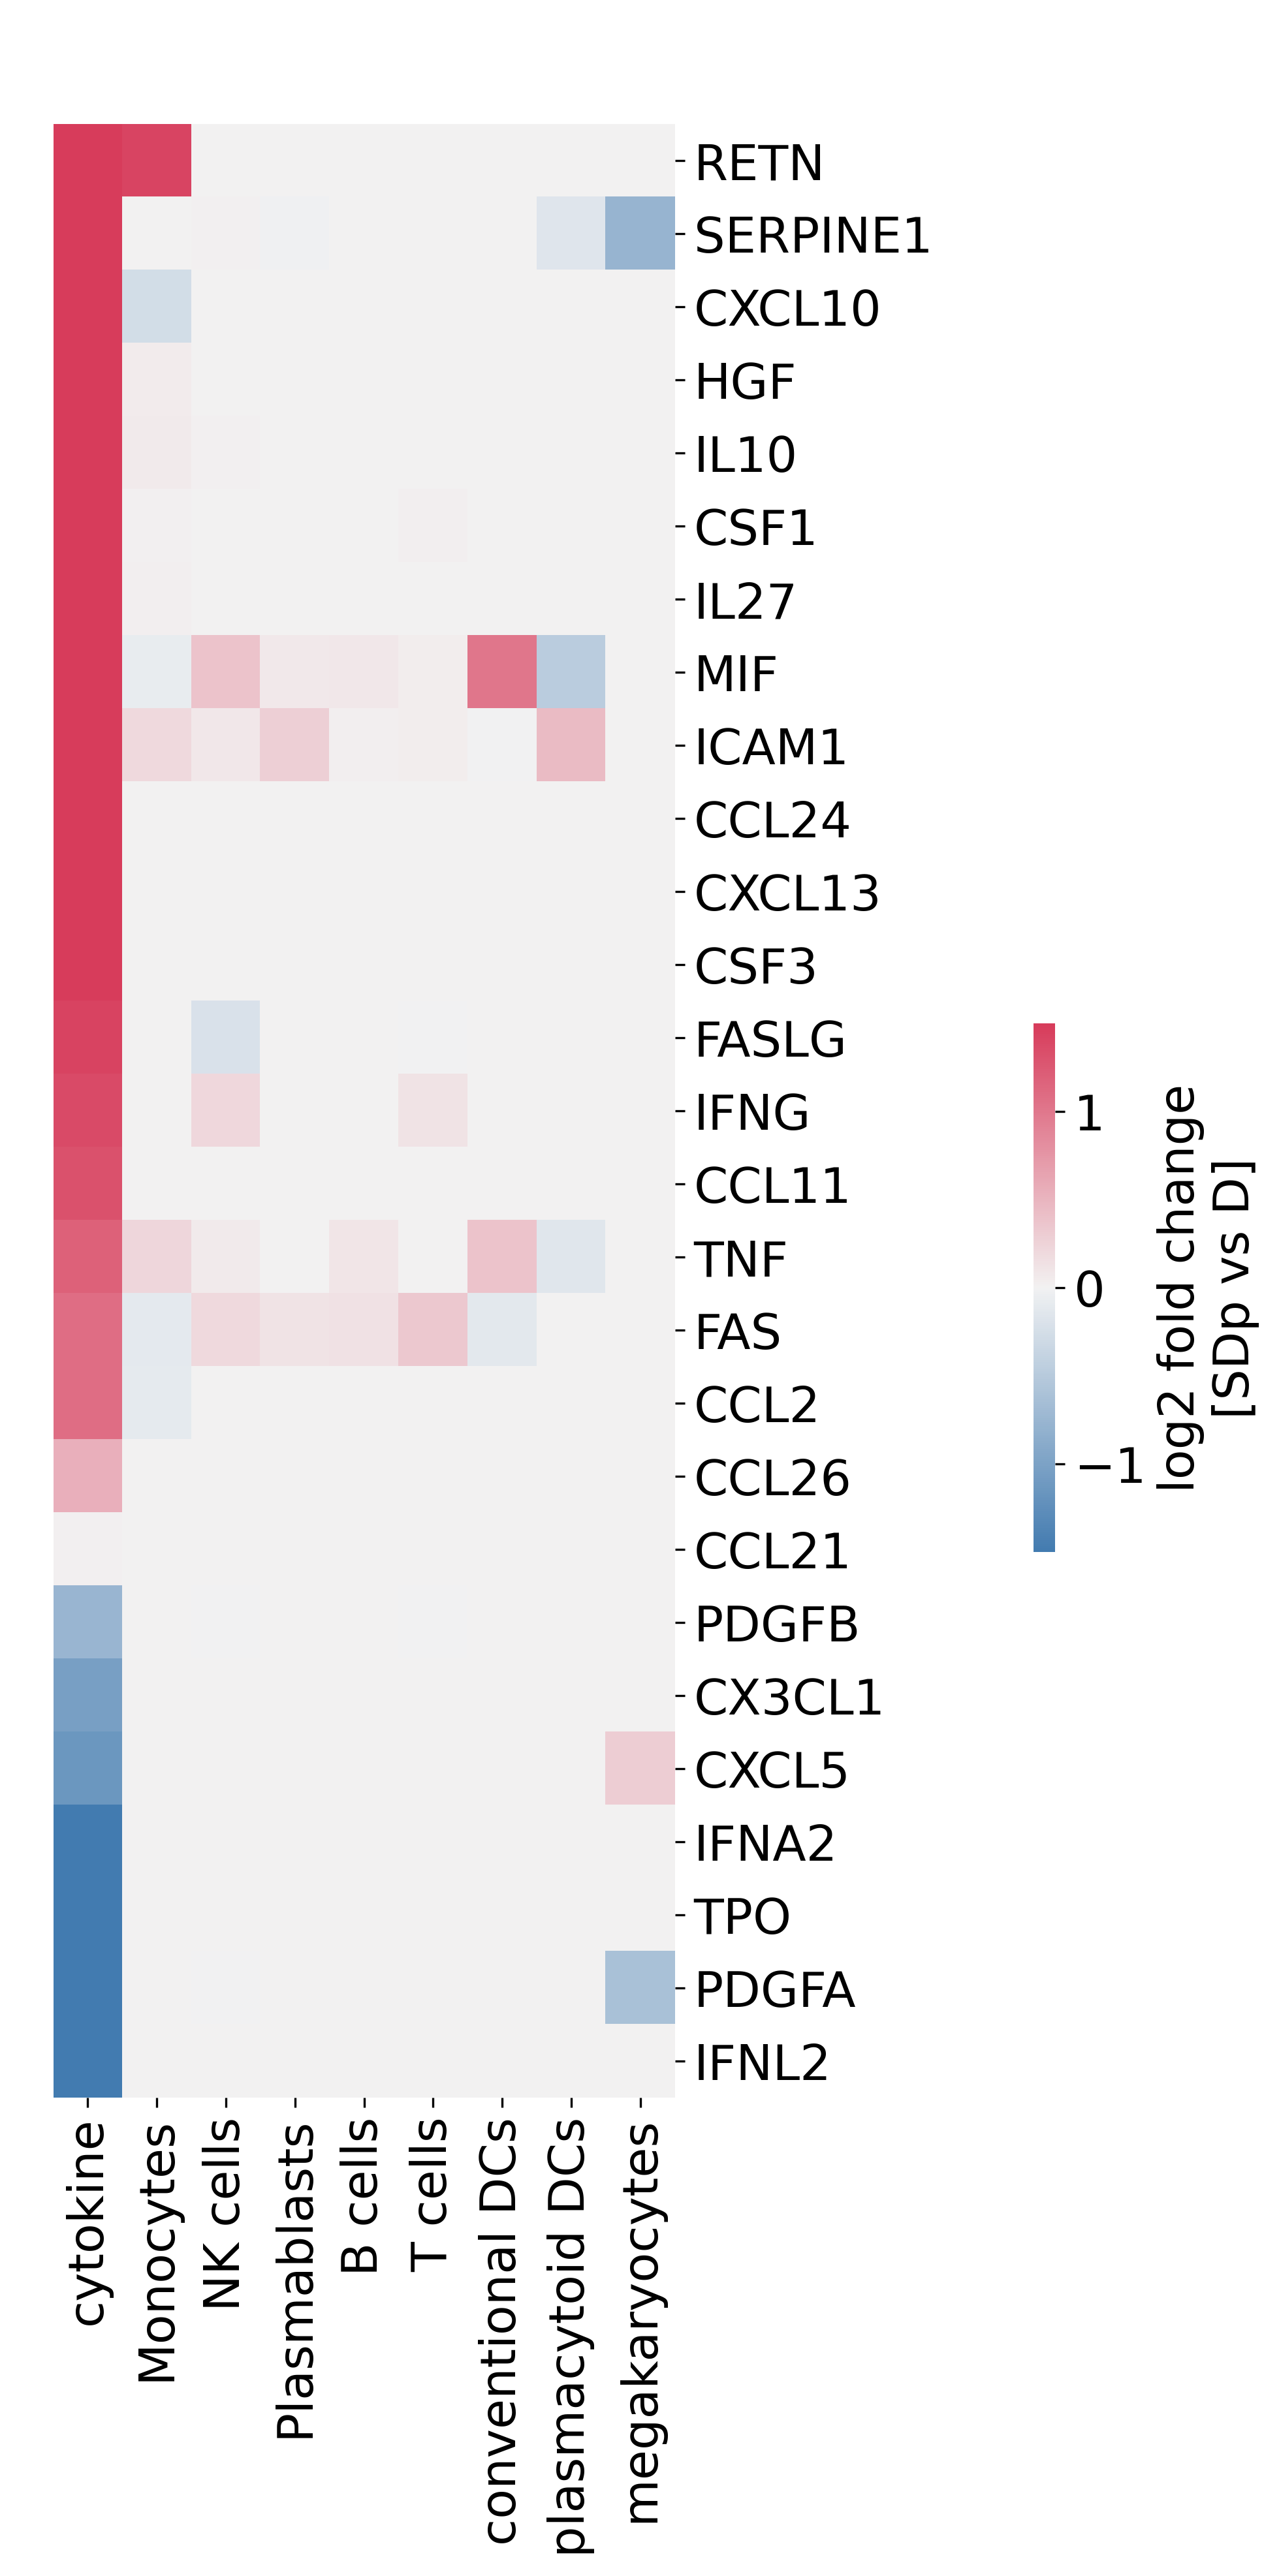

In [111]:
# '''medium log2 fold change from pairwise comparison of all significant cytokines
# in distinct cell types in our dataset and blood'''

pair_mix = ct_pair[['med_pair']].reset_index()

cyto_mix = pair[['med_pair']].reset_index()
cyto_mix['cell_subtype'] = 'cytokine'
pair_mix = pd.concat([pair_mix, cyto_mix])

heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, 1.5, 'med_pair', vs_type='SDp vs D', save_fd='sig_cyto_mix.png')
heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, 1.5, 'med_pair', vs_type='SDp vs D', save_fd='sig_cyto_mix.pdf')

####
# '''log2 fold change from pairwise comparison of all significant cytokines
# in distinct cell types in our dataset and blood'''

pair_mix = ct_pair[['log2_fold_change']].reset_index()

cyto_mix = pair[['log2_fold_change']].reset_index()
cyto_mix['cell_subtype'] = 'cytokine'
pair_mix = pd.concat([pair_mix, cyto_mix])

heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['log2_fold_change', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, 3, 'log2_fold_change', vs_type='SDp vs D', save_fd='sig_cyto_mix2.png')
heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['log2_fold_change', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, 3, 'log2_fold_change', vs_type='SDp vs D', save_fd='sig_cyto_mix2.pdf')

####
# '''medium log2 fold change from pairwise comparison of all significant cytokines
# in distinct cell subtypes in our dataset and blood'''
pair_mix = cst_pair[['med_pair']].reset_index()

cyto_mix = pair[['med_pair']].reset_index()
cyto_mix['cell_subtype'] = 'cytokine'
pair_mix = pd.concat([pair_mix, cyto_mix])

heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + csts, 3, 'med_pair', vs_type='SDp vs D', save_fd='sig_cyto_mix_cst.png')
heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + csts, 3, 'med_pair', vs_type='SDp vs D', save_fd='sig_cyto_mix_cst1.pdf')

####
# '''log2 fold change from pairwise comparison of all significant cytokines
# in distinct cell subtypes in our dataset and blood'''
pair_mix = cst_pair[['log2_fold_change']].reset_index()

cyto_mix = pair[['log2_fold_change']].reset_index()
cyto_mix['cell_subtype'] = 'cytokine'
pair_mix = pd.concat([pair_mix, cyto_mix])

heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['log2_fold_change', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + csts, 3, 'log2_fold_change', vs_type='SDp vs D', save_fd='sig_cyto_mix_cst2.png')
heatmap_cst(pair_mix, pair[pair['pvalue_U'] < 0.05].sort_values(['log2_fold_change', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + csts, 3, 'log2_fold_change', vs_type='SDp vs D', save_fd='sig_cyto_mix_cst2.pdf')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


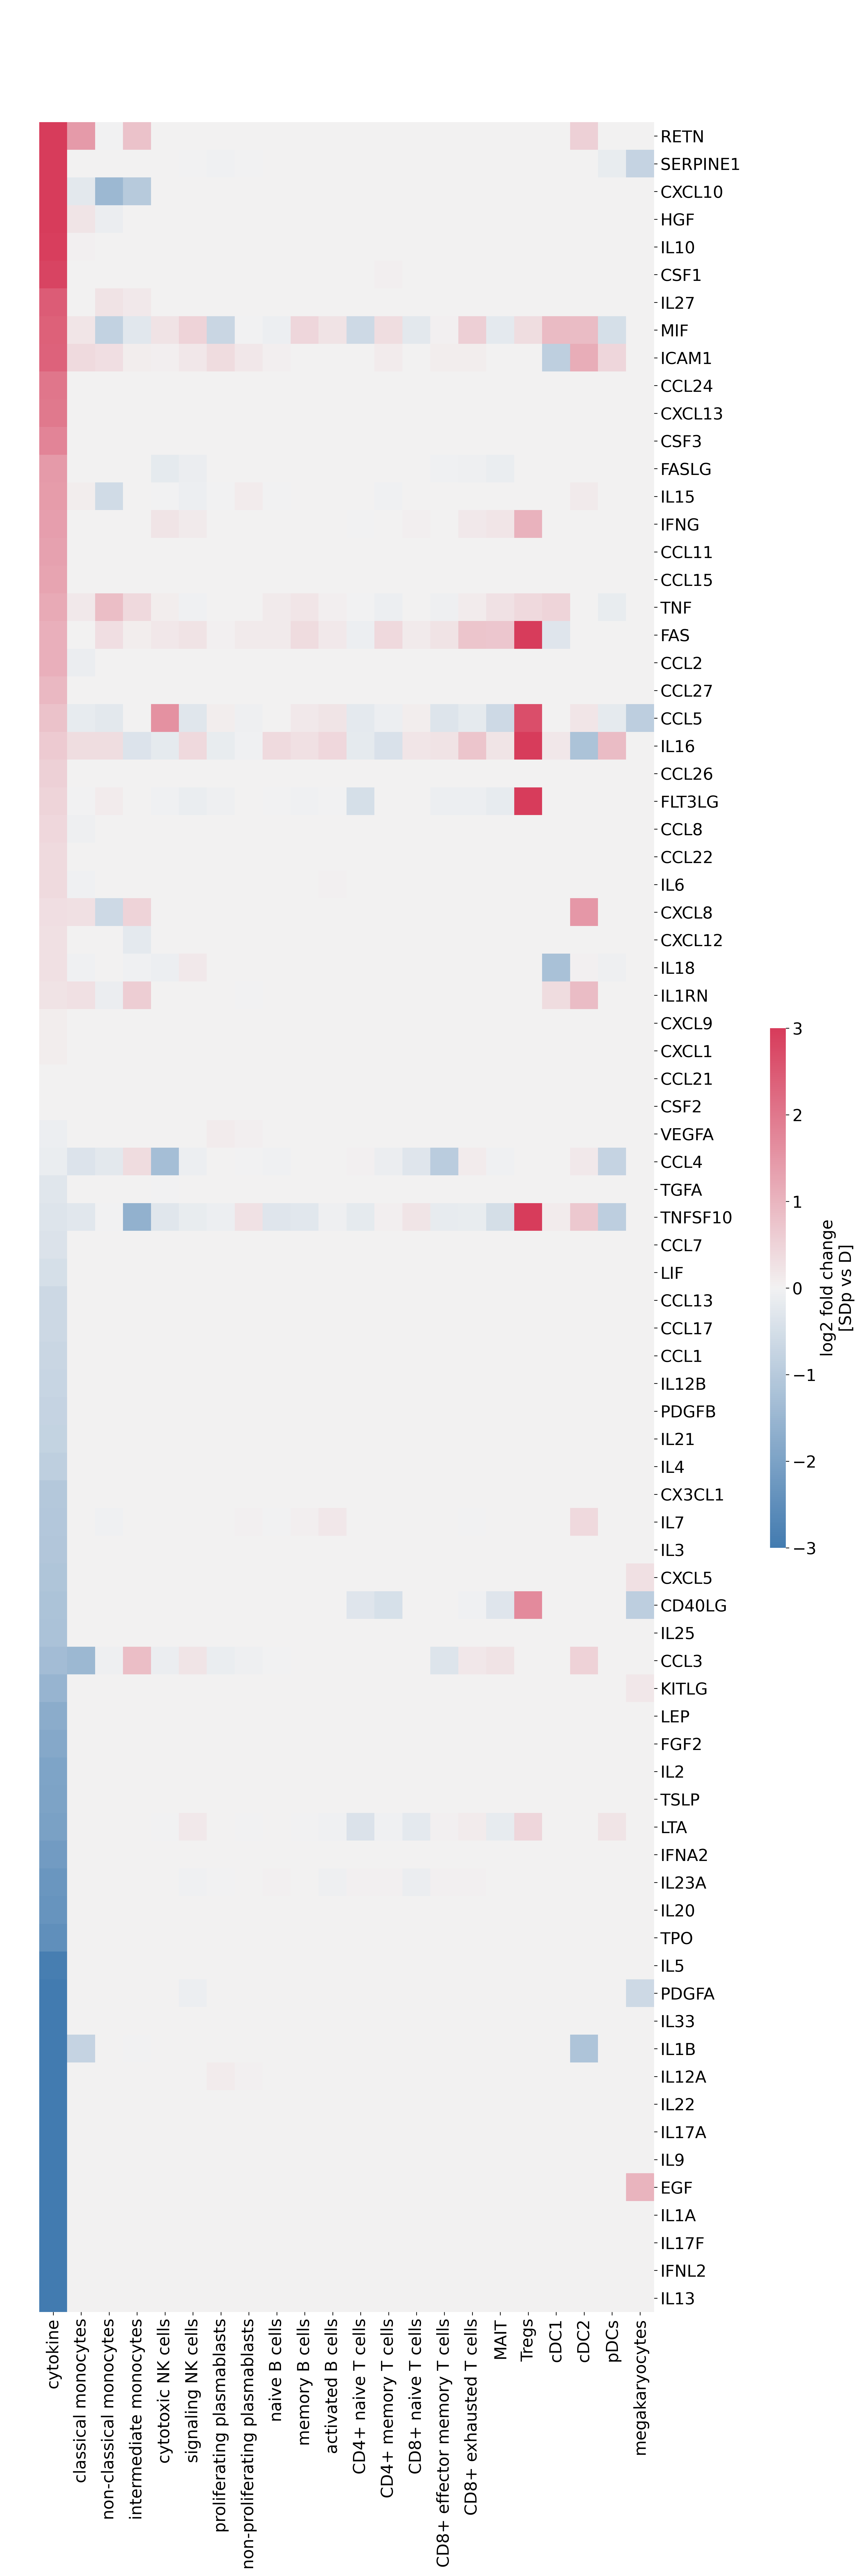

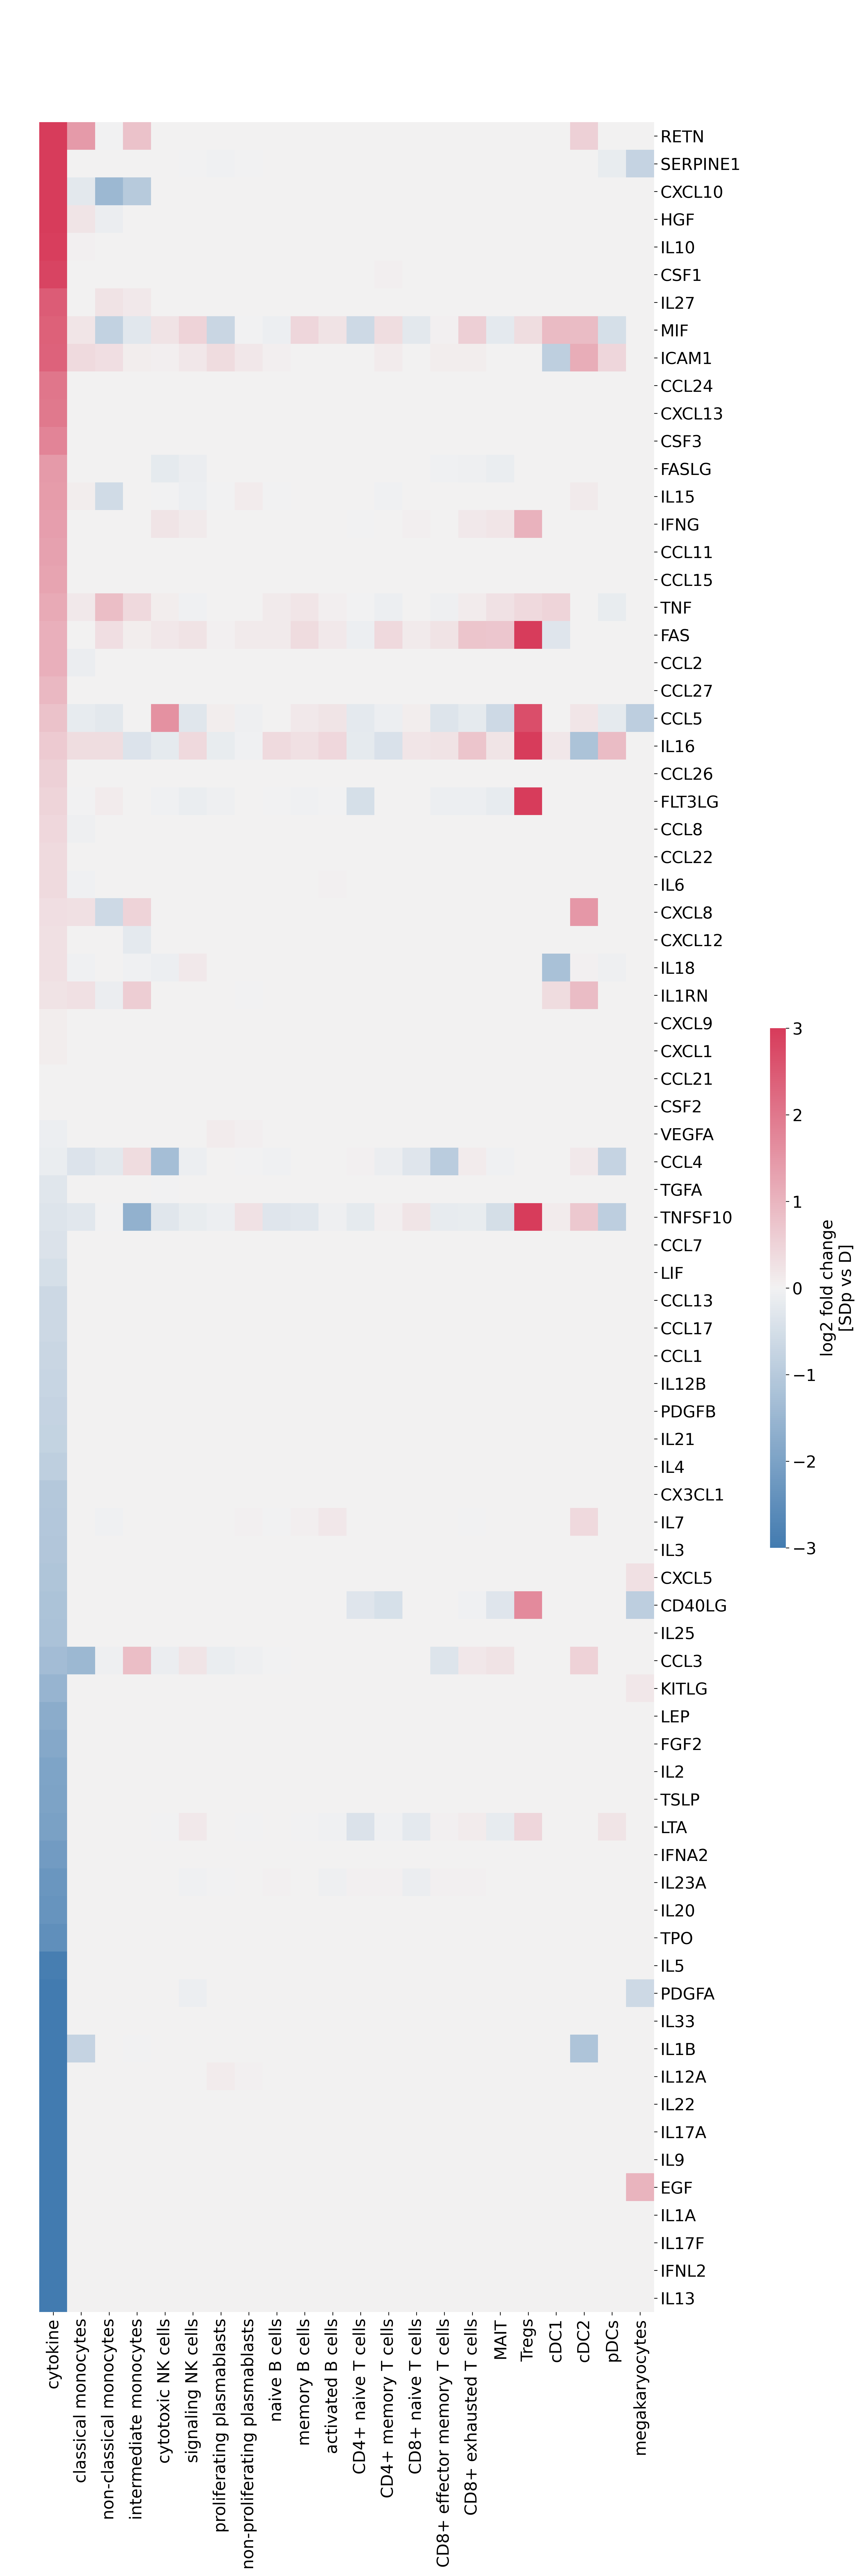

In [11]:
# '''medium log2 fold change from pairwise comparison of all cytokines
# in distinct cell subtypes in our dataset and blood'''
pair_mix_ct = ct_pair[['med_pair']].reset_index()

cyto_mix = pair[['med_pair']].reset_index()
cyto_mix['cell_subtype'] = 'cytokine'
pair_mix_ct = pd.concat([pair_mix_ct, cyto_mix])

heatmap_cst(pair_mix_ct, pair.sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, 3, 'med_pair', vs_type='SDp vs D', 
            save_fd='cyto_mix_ct_pair.png')
heatmap_cst(pair_mix_ct, pair.sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, 3, 'med_pair', vs_type='SDp vs D', 
            save_fd='cyto_mix_ct_pair.pdf')

###########################
pair_mix_cst = cst_pair[['med_pair']].reset_index()

cyto_mix = pair[['med_pair']].reset_index()
cyto_mix['cell_subtype'] = 'cytokine'
pair_mix_cst = pd.concat([pair_mix_cst, cyto_mix])

heatmap_cst(pair_mix_cst, pair.sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + csts, 3, 'med_pair', vs_type='SDp vs D', 
            save_fd='cyto_mix_cst_pair.png')
heatmap_cst(pair_mix_cst, pair.sort_values(['med_pair', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + csts, 3, 'med_pair', vs_type='SDp vs D', 
            save_fd='cyto_mix_cst_pair.pdf')

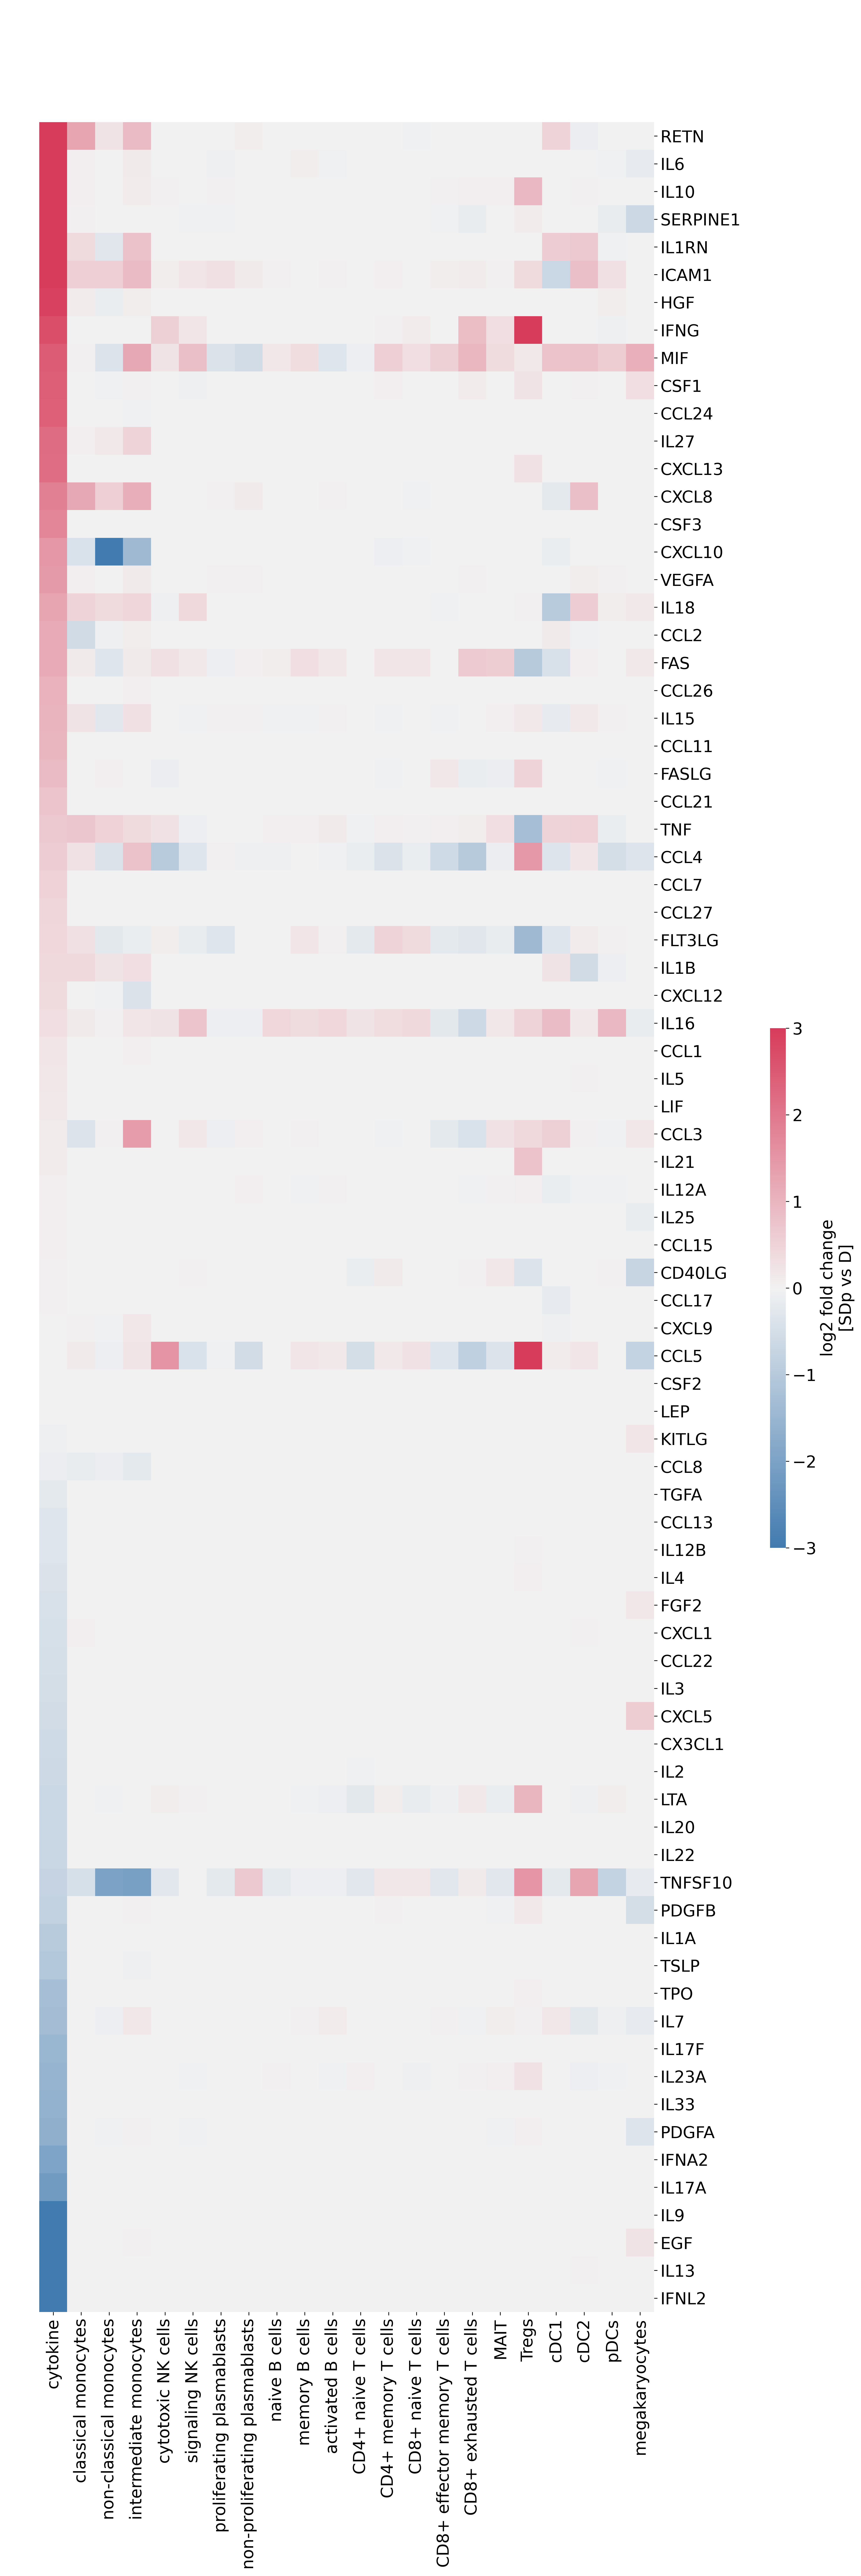

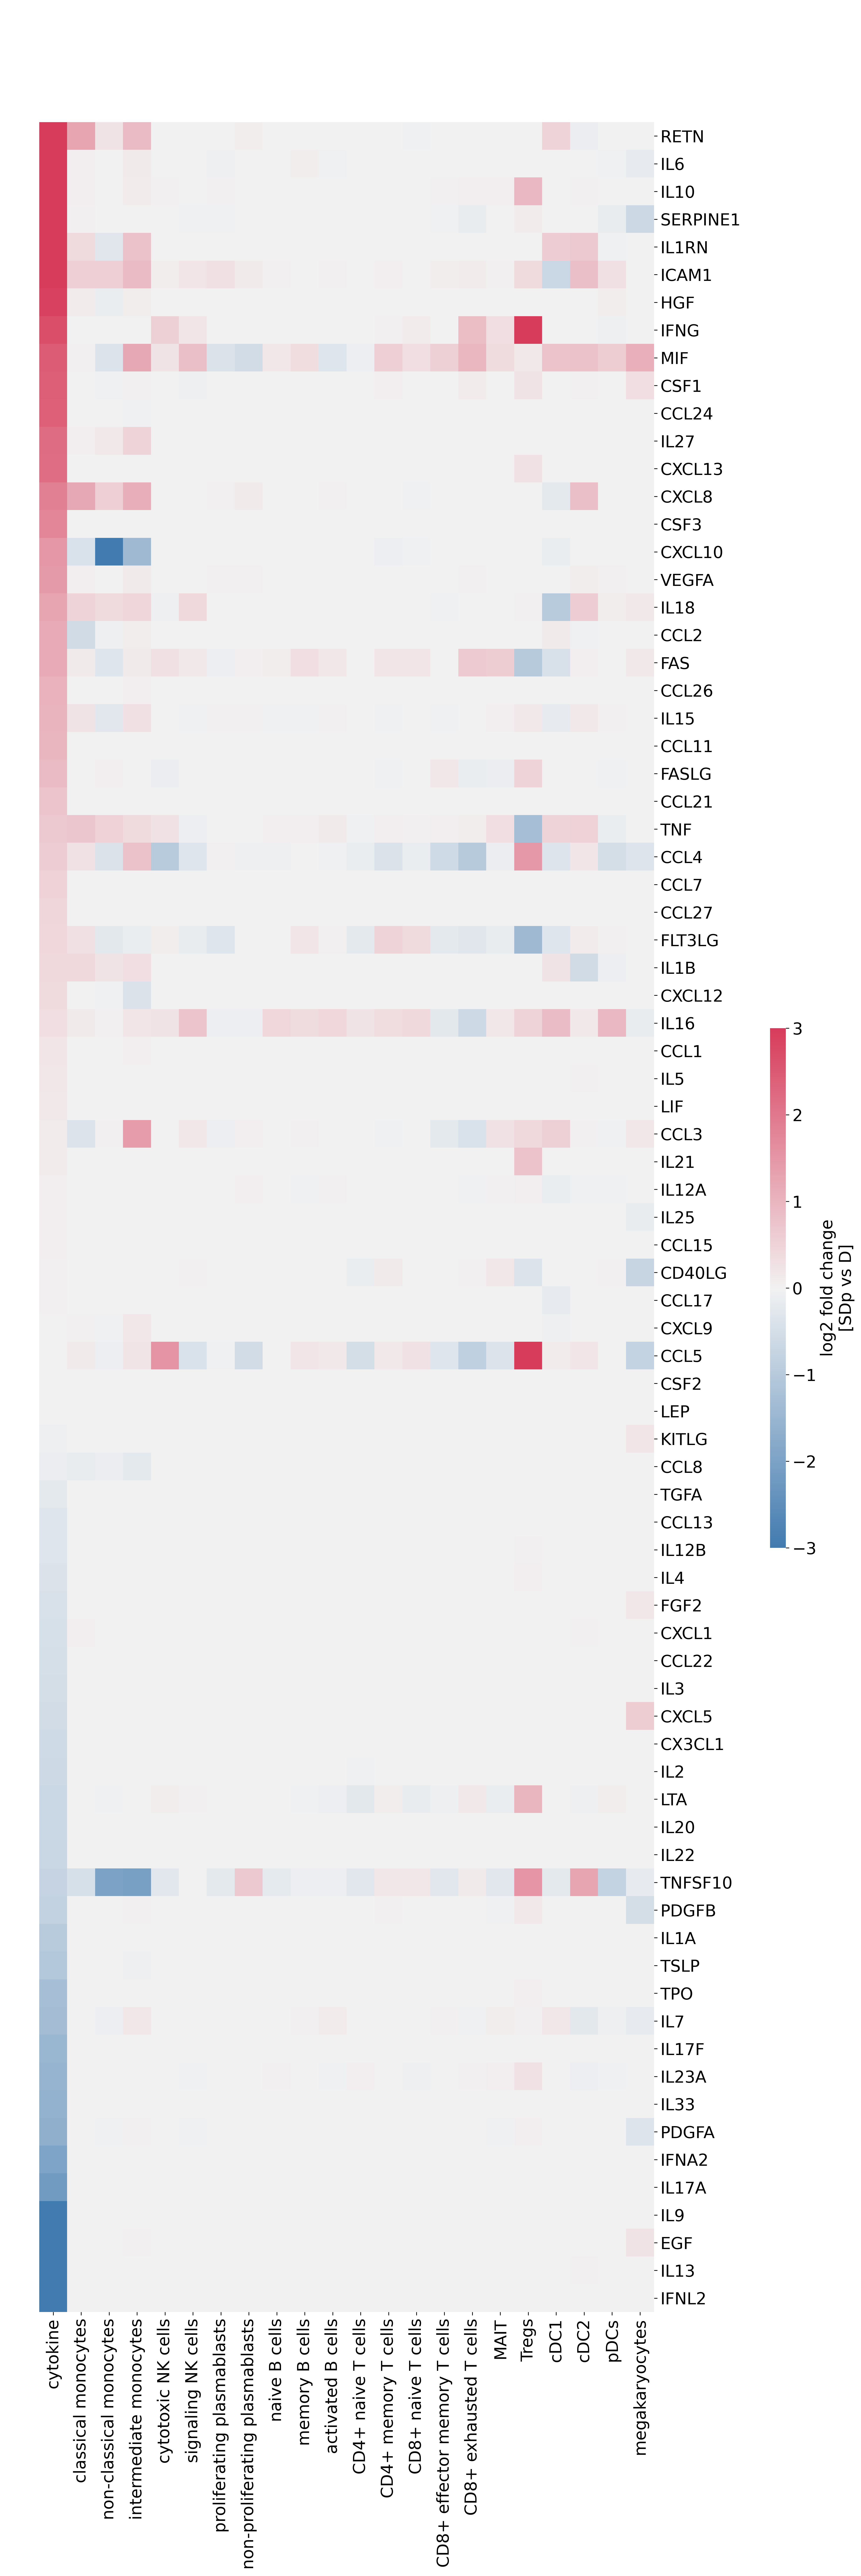

In [13]:
# '''log2 fold change from pairwise comparison of all significant cytokines
# in distinct cell subtypes in our dataset and blood'''
pair_mix_ct = ct_pair[['log2_fold_change']].reset_index()

cyto_mix = pair[['log2_fold_change']].reset_index()
cyto_mix['cell_subtype'] = 'cytokine'
pair_mix_ct = pd.concat([pair_mix_ct, cyto_mix])

heatmap_cst(pair_mix_ct, pair.sort_values(['log2_fold_change', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, 3, 'log2_fold_change', vs_type='SDp vs D', 
            save_fd='cyto_mix_ct_log2FC.png')
heatmap_cst(pair_mix_ct, pair.sort_values(['log2_fold_change', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + cts, 3, 'log2_fold_change', vs_type='SDp vs D', 
            save_fd='cyto_mix_ct_log2FC.pdf')

####
pair_mix_cst = cst_pair[['log2_fold_change']].reset_index()

cyto_mix = pair[['log2_fold_change']].reset_index()
cyto_mix['cell_subtype'] = 'cytokine'
pair_mix_cst = pd.concat([pair_mix_cst, cyto_mix])

heatmap_cst(pair_mix_cst, pair.sort_values(['log2_fold_change', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + csts, 3, 'log2_fold_change', vs_type='SDp vs D', 
            save_fd='cyto_mix_cst_log2FC.png')
heatmap_cst(pair_mix_cst, pair.sort_values(['log2_fold_change', 'avg_SD'], ascending=False).index, 
            ['cytokine'] + csts, 3, 'log2_fold_change', vs_type='SDp vs D', 
            save_fd='cyto_mix_cst_log2FC.pdf')

In [98]:
def get_inters_med_pair(interactions, sig_cytos, cyto_pair, data_ct, cts, 
                        med_pair_cut_off, fra_pair_cut_off, fra_exp_cut_off):
    
    res = []
    for _, row in interactions.iterrows():
        lig = row['genesymbol_intercell_source'] # ligand
        rcp = row['genesymbol_intercell_target'] # receptor
        
        if lig in sig_cytos:
            ga = lig
            gb = rcp
            
        else:
            ga = rcp
            gb = lig
        
        print(ga, gb)
        for ct in cts:
            ct_med = data_ct.loc[ct, gb]['med_pair'][0]
            ct_fra_pair = data_ct.loc[ct, gb]['fra_pair'][0]
            ct_neg_fra_pair = data_ct.loc[ct, gb]['neg_fra_pair'][0]
            ct_fra = {cd: data_ct.loc[ct, gb][cd + '_fra'][0] for cd in ['S', 'NS']}
            print(ct)
            
            #####################
            if ((cyto_pair.loc[ga]['med_pair'] > 0) & 
                (ct_med > med_pair_cut_off) & 
                (ct_fra['S'] > fra_exp_cut_off) & 
                (ct_fra_pair > fra_pair_cut_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           np.array(data_ct.loc[ct, gb])[0].tolist() + ['up'])

            elif ((cyto_pair.loc[ga]['med_pair'] < 0) & 
                  (ct_med < -med_pair_cut_off) & 
                  (ct_fra['NS'] > fra_exp_cut_off) & 
                  (ct_neg_fra_pair > fra_pair_cut_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           np.array(data_ct.loc[ct, gb])[0].tolist() + ['down'])
                
            elif ((cyto_pair.loc[ga]['med_pair'] > 0) & 
                  (ct_med < -med_pair_cut_off) & 
                  (ct_fra['NS'] > fra_exp_cut_off) & 
                  (ct_neg_fra_pair > fra_pair_cut_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           np.array(data_ct.loc[ct, gb])[0].tolist() + ['mix'])
                
            elif ((cyto_pair.loc[ga]['med_pair'] < 0) & 
                  (ct_med > med_pair_cut_off) & 
                  (ct_fra['S'] > fra_exp_cut_off) & 
                  (ct_fra_pair > fra_pair_cut_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           np.array(data_ct.loc[ct, gb])[0].tolist() + ['mix'])
  
    res = pd.DataFrame(res, columns = ['cytokine'] + [col + '_cyto' for col in pair.columns] + ['receptor', 'celltype'] + [col + '_rcp' for col in ct_pair.columns] + ['inter_type'])
    
    return res

def get_inters_log2FC(interactions, sig_cytos, cyto_pair, data_ct, cts, 
                        log2FC_off, pvalue_off):
    
    res = []
    for _, row in interactions.iterrows():
        lig = row['genesymbol_intercell_source'] # ligand
        rcp = row['genesymbol_intercell_target'] # receptor
        
        if lig in sig_cytos:
            ga = lig
            gb = rcp
            
        else:
            ga = rcp
            gb = lig
        
        print(ga, gb)
        for ct in cts:
            ct_log2FC = data_ct.loc[ct, gb]['log2_fold_change']
            ct_pvalue = data_ct.loc[ct, gb]['pvalue_corrected']
            print(ct)
            
            #####################
            if ((cyto_pair.loc[ga]['med_pair'] > 0) & 
                (ct_log2FC > log2FC_off) & 
                (ct_pvalue < pvalue_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           np.array(data_ct.loc[ct, gb]).tolist() + ['up'])

            elif ((cyto_pair.loc[ga]['med_pair'] < 0) & 
                  (ct_log2FC < -log2FC_off) & 
                  (ct_pvalue < pvalue_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           np.array(data_ct.loc[ct, gb]).tolist() + ['down'])
                
            elif ((cyto_pair.loc[ga]['med_pair'] > 0) & 
                 (ct_log2FC < -log2FC_off) & 
                 (ct_pvalue < pvalue_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           np.array(data_ct.loc[ct, gb]).tolist() + ['mix'])
                
            elif ((cyto_pair.loc[ga]['med_pair'] < 0) & 
                 (ct_log2FC > log2FC_off) & 
                 (ct_pvalue < pvalue_off)):
                res.append([ga] + cyto_pair.loc[ga].tolist() + [gb, ct] + 
                           np.array(data_ct.loc[ct, gb]).tolist() + ['mix'])
  
    res = pd.DataFrame(res, columns = ['cytokine'] + [col + '_cyto' for col in pair.columns] + ['receptor', 'celltype'] + [col + '_rcp' for col in ct_pair.columns] + ['inter_type'])
    
    return res

In [15]:
cyto_inters = pd.read_csv('/home/yike/phd/dengue/data/sig_cytokine_interactions.tsv', sep='\t')
# cyto_inters = cyto_inters[cyto_inters['genesymbol_intercell_source'].isin(sig_cytos) |
#                           cyto_inters['genesymbol_intercell_target'].isin(sig_cytos)]

not_recp = ['CCR3', 'CCR4', 'CCR8', 'CXCR1', 'CXCR2', 'TNFRSF11B']
cyto_inters =  cyto_inters[(cyto_inters['genesymbol_intercell_source'].isin(sig_cytos)) & 
                           (~ cyto_inters['genesymbol_intercell_target'].isin(not_recp)) |
                           (~ cyto_inters['genesymbol_intercell_source'].isin(not_recp)) &
                           (cyto_inters['genesymbol_intercell_target'].isin(sig_cytos))
                          ]
cyto_pairs = cyto_inters[cyto_inters['genesymbol_intercell_source'].isin(ct_pair.loc['B cells'].index.unique()) &
                         cyto_inters['genesymbol_intercell_target'].isin(ct_pair.loc['B cells'].index.unique())]

In [16]:
# interactions via pairwise comparison
ct_res = get_inters_med_pair(cyto_inters, sig_cytos, pair, ct_pair, cts, 
                                1, 0.02, 39/56)

cst_res = get_inters_med_pair(cyto_inters, sig_cytos, pair, cst_pair, csts, 
                                1, 0.02, 39/56)

ct_res.to_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/cytokines/sig_cyto_ct_interactions_pairwise.tsv', 
              sep='\t', index=False)

cst_res.to_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/cytokines/sig_cyto_cst_interactions_pairwise.tsv', 
              sep='\t', index=False)

In [101]:
# interactions via log2 fold change
ct_res_log2FC = get_inters_log2FC(cyto_inters, sig_cytos, pair, ct_pair, cts, 
                                1, 0.05)
ct_res_log2FC.to_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/cytokines/sig_cyto_ct_interactions_log2FC.tsv', 
              sep='\t', index=False)

cst_res_log2FC = get_inters_log2FC(cyto_inters, sig_cytos, pair, cst_pair, csts, 
                                1, 0.05)
cst_res_log2FC.to_csv('/home/yike/phd/dengue/docs/paper_draft/tabels/cytokines/sig_cyto_cst_interactions_log2FC.tsv', 
              sep='\t', index=False)

1

### interactions from pairwise comparison

In [97]:
up # 16

cytokine  med_pair_cyto  fra_pair_cyto  neg_fra_pair_cyto  \
2      CSF3       1.793419          1.000                0.0   
3       TNF       1.194785          1.000                0.0   
4       TNF       1.194785          1.000                0.0   
5       FAS       1.088286          1.000                0.0   
6       FAS       1.088286          1.000                0.0   
7       FAS       1.088286          1.000                0.0   
9       HGF       3.001875          1.000                0.0   
10      HGF       3.001875          1.000                0.0   
12    ICAM1       2.354819          1.000                0.0   
13    ICAM1       2.354819          1.000                0.0   
15     IFNG       1.371872          1.000                0.0   
16     IL10       2.940394          1.000                0.0   
17    ICAM1       2.354819          1.000                0.0   
18    ICAM1       2.354819          1.000                0.0   
20     RETN      14.015823          0.875                0.0   
21     CSF1       2.847307          1.000                0.0   

    statistic_U_cyto  pvalue_U_cyto    avg_D_cyto   avg_SD_cyto  receptor  \
2               10.0       0.023639      57.22125  1.957988e+02     IGHG3   
3                9.0       0.018129     215.25875  3.425688e+02      CTSB   
4                9.0       0.018129     215.25875  3.425688e+02      CTSB   
5                0.0       0.000931   24538.04125  5.542299e+04     PTPRC   
6                0.0       0.000931   24538.04125  5.542299e+04     PTPRC   
7                0.0       0.000931   24538.04125  5.542299e+04     PTPRC   
9                8.0       0.013518     133.70125  9.874225e+02     ANXA1   
10               8.0       0.013518     133.70125  9.874225e+02     ITGB1   
12               7.0       0.010082  161226.59500  1.507389e+06     ITGB2   
13               7.0       0.010082  161226.59500  1.507389e+06     ITGB2   
15               3.0       0.002762      24.88625  1.608700e+02  HSP90AA1   
16               4.0       0.003772      28.23750  3.225587e+02      CD14   
17               7.0       0.010082  161226.59500  1.507389e+06     ITGB2   
18               7.0       0.010082  161226.59500  1.507389e+06     ITGB2   
20               4.0       0.001446       0.00000  6.890869e+04      CAP1   
21               8.0       0.013587     310.74000  1.658181e+03      SELL   

            celltype  ...  neg_fra_pair_rcp  S_fra_rcp  NS_fra_rcp  \
2       Plasmablasts  ...          0.281250   0.775251    0.568212   
3          Monocytes  ...          0.142857   0.761716    0.606295   
4   conventional DCs  ...          0.250000   0.740909    0.610390   
5   conventional DCs  ...          0.222222   0.900000    0.707792   
6           NK cells  ...          0.125000   0.891733    0.793778   
7            T cells  ...          0.125000   0.882928    0.761197   
9   conventional DCs  ...          0.111111   0.968182    0.870130   
10    megakaryocytes  ...          0.250000   0.800000    0.571429   
12         Monocytes  ...          0.214286   0.905552    0.725653   
13  conventional DCs  ...          0.111111   0.959091    0.844156   
15  conventional DCs  ...          0.194444   0.836364    0.740260   
16         Monocytes  ...          0.214286   0.846431    0.597387   
17         Monocytes  ...          0.214286   0.905552    0.725653   
18  conventional DCs  ...          0.111111   0.959091    0.844156   
20  conventional DCs  ...          0.138889   0.959091    0.753247   
21  conventional DCs  ...          0.111111   0.850000    0.590909   

     S_avg_rcp  NS_avg_rcp  log2_fold_change_rcp  statistic_rcp  \
2   232.202271   42.959938              2.407321       0.233399   
3   122.035492   44.981697              1.419943       0.155655   
4    56.524273   28.460016              0.965413       0.148052   
5   234.966965   61.257530              1.922265       0.274026   
6   573.193359  254.925812              1.165811       0.148146   
7   484.629

In [95]:
down

cytokine  med_pair_cyto  fra_pair_cyto  neg_fra_pair_cyto  \
22    PDGFB      -0.752506            0.0                1.0   

    statistic_U_cyto  pvalue_U_cyto  avg_D_cyto  avg_SD_cyto receptor  \
22              55.0       0.018129  14623.0425      8308.58    SPARC   

          celltype  ...  neg_fra_pair_rcp  S_fra_rcp  NS_fra_rcp   S_avg_rcp  \
22  megakaryocytes  ...              0.75   0.727273    0.946429  244.346497   

     NS_avg_rcp  log2_fold_change_rcp  statistic_rcp  pvalue_rcp  \
22  1113.600952             -2.183635       0.219156    0.116265   

    pvalue_corrected_rcp  inter_type  
22                   1.0        down  

[1 rows x 22 columns]

In [99]:
mix

cytokine  med_pair_cyto  fra_pair_cyto  neg_fra_pair_cyto  \
23      TNF       1.194785            1.0                0.0   

    statistic_U_cyto  pvalue_U_cyto  avg_D_cyto  avg_SD_cyto receptor  \
23               9.0       0.018129   215.25875    342.56875     ESAM   

          celltype  ...  neg_fra_pair_rcp  S_fra_rcp  NS_fra_rcp   S_avg_rcp  \
23  megakaryocytes  ...               1.0   0.690909    0.785714  137.379364   

    NS_avg_rcp  log2_fold_change_rcp  statistic_rcp  pvalue_rcp  \
23  271.603821             -0.978177       0.141883    0.577137   

    pvalue_corrected_rcp  inter_type  
23                   1.0         mix  

[1 rows x 22 columns]

In [109]:
ct_res_log2FC[ct_res_log2FC['inter_type'] == 'up'].set_index(['cytokine', 'receptor', 'celltype'])

med_pair_cyto  fra_pair_cyto  \
cytokine receptor celltype                                         
CCL11    CCR2     Plasmablasts           1.312612          1.000   
CCL2     CCR2     Plasmablasts           1.081449          1.000   
CCL21    CCR2     Plasmablasts           0.017033          0.500   
CCL24    CCR2     Plasmablasts           2.031769          0.750   
CCL26    CCR2     Plasmablasts           0.540978          1.000   
CSF1     CSF3R    Monocytes              2.847307          1.000   
                  conventional DCs       2.847307          1.000   
CSF3     CSF3R    Monocytes              1.793419          1.000   
                  conventional DCs       1.793419          1.000   
         FPR1     Monocytes              1.793419          1.000   
         IGHG3    Plasmablasts           1.793419          1.000   
                  conventional DCs       1.793419          1.000   
         PLAUR    Monocytes              1.793419          1.000   
TNF      CTSB     Monocytes              1.194785          1.000   
CXCL10   CCR2     Plasmablasts           3.040691          1.000   
CXCL13   CCR2     Plasmablasts           1.971751          1.000   
ICAM1    CXCL8    Monocytes              2.354819          1.000   
FAS      PTPRC    NK cells               1.088286          1.000   
                  Plasmablasts           1.088286          1.000   
                  B cells                1.088286          1.000   
                  T cells                1.088286          1.000   
                  conventional DCs       1.088286          1.000   
HGF      ANXA1    Monocytes              3.001875          1.000   
         CD44     Monocytes              3.001875          1.000   
         ITGB1    NK cells               3.001875          1.000   
                  conventional DCs       3.001875          1.000   
ICAM1    ITGAM    Monocytes              2.354819          1.000   
         ITGB2    Monocytes              2.354819          1.000   
                  T cells                2.354819          1.000   
                  conventional DCs       2.354819          1.000   
IFNG     ANPEP    Monocytes              1.371872          1.000   
         ANXA2    Monocytes              1.371872          1.000   
         FCGR1A   Monocytes              1.371872          1.000   
         IFNGR2   Monocytes              1.371872          1.000   
IL10     CD14     Monocytes              2.940394          1.000   
         IL10RA   NK cells               2.940394          1.000   
                  conventional DCs       2.940394          1.000   
ICAM1    ITGAM    Monocytes              2.354819          1.000   
TNF      ITGAM    Monocytes              1.194785          1.000   
ICAM1    ITGB2    Monocytes              2.354819          1.000   
                  T cells                2.354819          1.000   
                  conventional DCs       2.354819          1.000   
FAS      LCK      NK cells               1.088286          1.000   
FASLG    LCK      NK cells               1.436287          1.000   
MIF      CD44     Monocytes              2.367394          0.875   
RETN     CAP1     Monocytes             14.015823          0.875   
                  Plasmablasts          14.015823          0.875   
                  T cells               14.015823          0.875   
                  conventional DCs      14.015823          0.875   
CSF1     SELL     Monocytes              2.847307          1.000   
                  NK cells               2.847307          1.000   
                  Plasmablasts           2.847307          1.000   
                  B cells                2.847307          1.000   
                  conventional DCs       2.847307          1.000   
                  plasmacytoid DCs       2.847307          1.000   
SERPINE1 LRP1     Monocytes              3.410103          1.000   
         PLAUR    Monocytes              3.410103          1.000   
TNF      CD44     Monocy

In [104]:
ct_res_log2FC[ct_res_log2FC['inter_type'] == 'down']

Empty DataFrame
Columns: [cytokine, med_pair_cyto, fra_pair_cyto, neg_fra_pair_cyto, statistic_U_cyto, pvalue_U_cyto, avg_D_cyto, avg_SD_cyto, log2_fold_change_cyto, receptor, celltype, med_pair_rcp, fra_pair_rcp, neg_fra_pair_rcp, S_fra_rcp, NS_fra_rcp, S_avg_rcp, NS_avg_rcp, log2_fold_change_rcp, statistic_rcp, pvalue_rcp, pvalue_corrected_rcp, inter_type]
Index: []

[0 rows x 23 columns]

In [121]:
ct_res_log2FC[ct_res_log2FC['inter_type'] == 'mix'].set_index(['cytokine', 'receptor', 'celltype'])

med_pair_cyto  fra_pair_cyto  \
cytokine receptor celltype                                     
CCL21    CXCL10   Monocytes          0.017033          0.500   
CX3CL1   CCL5     NK cells          -1.032620          0.000   
         CCR2     Plasmablasts      -1.032620          0.000   
CXCL5    CCR2     Plasmablasts      -1.142256          0.000   
ICAM1    IL2RG    NK cells           2.354819          1.000   
                  Plasmablasts       2.354819          1.000   
IFNA2    IFNGR2   Monocytes         -2.173616          0.000   
IFNG     CD74     Plasmablasts       1.371872          1.000   
         CXCL10   Monocytes          1.371872          1.000   
PDGFB    LCK      NK cells          -0.752506          0.000   
MIF      CD74     Plasmablasts       2.367394          0.875   
PDGFB    LRP1     Monocytes         -0.752506          0.000   
         RAC1     Monocytes         -0.752506          0.000   
                  Plasmablasts      -0.752506          0.000   
                  T cells           -0.752506          0.000   
FAS      S100B    NK cells           1.088286          1.000   
TNF      S100B    NK cells           1.194785          1.000   
         CD38     NK cells           1.194785          1.000   
         CD59     Plasmablasts       1.194785          1.000   
         CXCL10   Monocytes          1.194785          1.000   

                                neg_fra_pair_cyto  statistic_U_cyto  \
cytokine receptor celltype                                            
CCL21    CXCL10   Monocytes                 0.500               8.5   
CX3CL1   CCL5     NK cells                  1.000              53.5   
         CCR2     Plasmablasts              1.000              53.5   
CXCL5    CCR2     Plasmablasts              1.000              52.5   
ICAM1    IL2RG    NK cells                  0.000               7.0   
                  Plasmablasts              0.000               7.0   
IFNA2    IFNGR2   Monocytes                 1.000              52.0   
IFNG     CD74     Plasmablasts              0.000               3.0   
         CXCL10   Monocytes                 0.000               3.0   
PDGFB    LCK      NK cells                  1.000              55.0   
MIF      CD74     Plasmablasts              0.125               6.0   
PDGFB    LRP1     Monocytes                 1.000              55.0   
         RAC1     Monocytes                 1.000              55.0   
                  Plasmablasts              1.000              55.0   
                  T cells                   1.000              55.0   
FAS      S100B    NK cells                  0.000               0.0   
TNF      S100B    NK cells                  0.000               9.0   
         CD38     NK cells                  0.000               9.0   
         CD59     Plasmablasts              0.000               9.0   
         CXCL10   Monocytes                 0.000               9.0   

                                pvalue_U_cyto    avg_D_cyto   avg_SD_cyto  \
cytokine receptor celltype                                                  
CCL21    CXCL10   Monocytes          0.015638    1393.05175  2.320949e+03   
CX3CL1   CCL5     NK cells           0.027083     273.44125  1.806125e+02   
         CCR2     Plasmablasts       0.027083     273.44125  1.806125e+02   
CXCL5    CCR2     Plasmablasts       0.035556     196.79750  1.351712e+02   
ICAM1    IL2RG    NK cells           0.010082  161226.59500  1.507389e+06   
                  Plasmablasts       0.010082  161226.59500  1.507389e+06   
IFNA2    IFNGR2   Monocytes          0.040274     161.96500  4.184250e+01   
IFNG     CD74     Plasmablasts       0.002762      24.88625  1.608700e+02   
         CXCL10   Monocytes          0.002762      24.88625  1.608700e+02   
PDGFB    LCK      NK cells           0.018129   14623.04250  8.308580e+03   
MIF      CD74     Plasmablasts       0.007406     387.23625  2.125051e+03   
PDGFB    LRP1     Monocytes          0.018129   14623.04250